### imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.graphics.gofplots import qqplot

from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, FunctionTransformer, PowerTransformer,\
                                  Normalizer, PowerTransformer, QuantileTransformer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.impute import SimpleImputer, MissingIndicator, KNNImputer
#from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score, \
                                    cross_val_predict, cross_validate, GridSearchCV, KFold, ShuffleSplit
from sklearn.utils.class_weight import compute_sample_weight

from pylab import rcParams

from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from textwrap import wrap

import warnings; 
warnings.simplefilter('ignore')

from IPython.display import display
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 999

plt.style.use('seaborn-white')

ModuleNotFoundError: No module named 'numpy'

# Data Overview

Read training data and info

In [3]:
data_train = pd.read_csv('train.csv')
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3865 entries, 0 to 3864
Data columns (total 80 columns):
 #   Column                                                                                   Non-Null Count  Dtype  
---  ------                                                                                   --------------  -----  
 0   galactic year                                                                            3865 non-null   int64  
 1   galaxy                                                                                   3865 non-null   object 
 2   existence expectancy index                                                               3864 non-null   float64
 3   existence expectancy at birth                                                            3864 non-null   float64
 4   Gross income per capita                                                                  3837 non-null   float64
 5   Income Index                                                  

In [3]:
data_train.shape

(3865, 80)

In [4]:
data_test = pd.read_csv('test.csv')

data_test['y'] = -1

#data_all = data_train.append(data_test, ignore_index=True)
data_all = pd.concat([data_train, data_test], keys=['train', 'test'])

In [ ]:
data_all.loc['train'].sort_values('y').iloc[[1,2,100,1000,2000,-100,-2,-1]].transpose()

In [5]:
data_all.iloc[:,2:] = data_all.iloc[:,2:].astype(np.float32)
data_train = data_all.loc['train']
data_test = data_all.loc['test'].iloc[:,:-1]
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3865 entries, 0 to 3864
Data columns (total 80 columns):
 #   Column                                                                                   Non-Null Count  Dtype  
---  ------                                                                                   --------------  -----  
 0   galactic year                                                                            3865 non-null   int64  
 1   galaxy                                                                                   3865 non-null   object 
 2   existence expectancy index                                                               3864 non-null   float32
 3   existence expectancy at birth                                                            3864 non-null   float32
 4   Gross income per capita                                                                  3837 non-null   float32
 5   Income Index                                                  

### Корреляции

In [181]:
data_wrk = data_train.drop(['galactic year','galaxy'], axis=1)
corr = data_wrk.corrwith(data_wrk['y'])
corr_spearman = data_wrk.corrwith(data_wrk['y'], method='spearman')
corr_kendall = data_wrk.corrwith(data_wrk['y'], method='kendall')
#rcParams['figure.figsize'] = 18, 18
#top_features = corr.index[(abs(corr['y'])>0.5) & (abs(corr_spearman['y'])>0.5) & (abs(corr_kendall['y'])>0.5)]
#sns.heatmap(data_wrk[top_features].corr(), vmin=-1, vmax=1, cmap='RdBu_r', square=True, annot=True);
#plt.show()

cols_corr_desc = pd.DataFrame((corr, corr_kendall, corr_spearman)).transpose().drop('y')
abs(cols_corr_desc).sort_values(by=[2,1,0], ascending=False)

0    1    2
Intergalactic Development Index (IDI), male, Rank  0.69 0.64 0.83
Intergalactic Development Index (IDI), Rank        0.68 0.64 0.82
Intergalactic Development Index (IDI), female, ... 0.67 0.62 0.81
Gender Inequality Index (GII)                      0.75 0.58 0.78
Intergalactic Development Index (IDI), female      0.64 0.57 0.76
Intergalactic Development Index (IDI), male        0.64 0.57 0.76
Life expectancy at birth, female (galactic years)  0.55 0.55 0.74
Intergalactic Development Index (IDI)              0.63 0.54 0.74
Young age (0-14) dependency ratio (per 100 crea... 0.60 0.53 0.72
existence expectancy at birth                      0.56 0.52 0.72
existence expectancy index                         0.55 0.51 0.71
Mortality rate, female grown up (per 1,000 people) 0.48 0.51 0.70
Mortality rate, kids (per 1,000 live births)       0.47 0.51 0.70
Education Index                                    0.61 0.50 0.69
Life expectancy at birth, male (galactic years)    0.55 0.50 0.69
Old age dependency ratio (old age (65 and older... 0.71 0.49 0.68
Mortality rate, infant (per 1,000 live births)     0.49 0.49 0.68
Mean years of education, female (galactic years)   0.58 0.49 0.68
Mean years of education (galactic years)           0.58 0.49 0.68
Mean years of education, male (galactic years)     0.58 0.48 0.68
Mortality rate, grown up (per 1,000 people)        0.50 0.49 0.67
Rural population with access to electricity (%)    0.50 0.48 0.67
Mortality rate, under-five (per 1,000 live births) 0.44 0.47 0.67
Population using at least basic sanitation serv... 0.48 0.47 0.66
Income Index                                       0.58 0.48 0.65
Vulnerable employment (% of total employment)      0.51 0.47 0.65
Maternal mortality ratio (deaths per 100,000 li... 0.39 0.46 0.65
Expected years of education, female (galactic y... 0.58 0.46 0.64
Adolescent birth rate (births per 1,000 female ... 0.52 0.46 0.64
Expected years of education (galactic years)       0.58 0.46 0.64
Population using at least basic drinking-water ... 0.43 0.44 0.63
Expected years of education, male (galactic years) 0.59 0.46 0.63
Population with at least some secondary educati... 0.53 0.44 0.63
Population with at least some secondary educati... 0.54 0.44 0.63
Employment in agriculture (% of total employment)  0.51 0.44 0.62
Population with at least some secondary educati... 0.51 0.42 0.61
Mortality rate, male grown up (per 1,000 people)   0.48 0.42 0.59
Estimated gross galactic income per capita, male   0.48 0.42 0.59
Gross galactic product (GGP) per capita            0.54 0.42 0.58
Estimated gross galactic income per capita, female 0.64 0.41 0.58
Employment in services (% of total employment)     0.50 0.40 0.57
Population, urban (%)                              0.50 0.39 0.57
Gross income per capita                            0.51 0.40 0.56
Gender Development Index (GDI)                     0.37 0.35 0.52
Respiratory disease incidence (per 100,000 people) 0.34 0.34 0.50
Renewable energy consumption (% of total final ... 0.28 0.31 0.47
Domestic credit provided by financial sector (%... 0.48 0.32 0.46
Creature Immunodeficiency Disease prevalence, a... 0.25 0.30 0.45
Interstellar Data Net users, total (% of popula... 0.64 0.30 0.44
Infants lacking immunization, Combination Vacci... 0.28 0.27 0.39
Infants lacking immunization, red hot disease (... 0.26 0.25 0.37
Mortality rate ratio                               0.09 0.24 0.34
Natural resource depletion                         0.22 0.22 0.32
Current health expenditure (% of GGP)              0.37 0.22 0.31
Years of education ratio                           0.20 0.21 0.31
Labour force participation rate (% ages 15 and ... 0.24 0.21 0.30
Interstellar phone subscriptions (per 100 people)  0.39 0.19 0.27
Intergalactic Development Index (IDI) ratio        0.21 0.17 0.26
Expected years of education ratio                  0.15 0.14 0.22
Mean years of education ratio                      0.16 0.14 0.22
Share of seats in senate (% 

In [ ]:
corr_plot = data_train[cols_corr_desc.index[(abs(cols_corr_desc) > 0.7).any(axis=1)]].corr('spearman')

rcParams['figure.figsize'] =30, 30

g = sns.heatmap(corr_plot, vmin=-1, vmax=1, cmap='RdBu_r', square=True, annot=True)

In [ ]:
def labels_wrap(label, lenght):
    xl = []
    while label:
        xl.append(label[:lenght])
        label = label[lenght:]
    return '\n'.join(xl)

#cols = cols_corr_desc.index[(abs(cols_corr_desc) > 0.7).any(axis=1)]
cols = notnan_columns + ['y']
corr_plot = data_train[cols].corr()

rcParams['figure.figsize'] =30, 30

g = sns.PairGrid(data_train[cols])
g = g.map_upper(sns.scatterplot)
g = g.map_lower(sns.kdeplot, colors="y")
g = g.map_diag(plt.hist, bins=30)

for ax in g.axes.flatten():
    # rotate x axis labels       
    ax.set_xlabel(labels_wrap(ax.get_xlabel(), 10), rotation = 0)
    # rotate y axis labels
    ax.set_ylabel(labels_wrap(ax.get_ylabel(), 10), rotation = 0)
    # set y labels alignment
    ax.yaxis.get_label().set_horizontalalignment('right')

#### Корреляции признаков между собой

In [ ]:
features_corr = data_train.drop('y', axis=1).corr()
features_corr -= np.eye(features_corr.shape[0])
features_corr.loc[(features_corr > 0.9).any(axis=1), (features_corr > 0.9).any(axis=0)]

### Отрицательные значения

Gross income per capita  Population, total (millions)  \
count                 3,837.00                      1,271.00   
mean                 31,633.24                        891.29   
std                  18,736.38                        894.15   
min                    -126.91                       -160.44   
25%                  20,169.12                        599.65   
50%                  26,600.77                        774.11   
75%                  36,898.63                        952.23   
max                 151,072.69                      7,993.32   

       Population, ages 15–64 (millions)  \
count                           1,264.00   
mean                              578.33   
std                               571.04   
min                               -91.29   
25%                               393.56   
50%                               501.29   
75%                               614.06   
max                             5,542.81   

       Population, ages 65 and older (millions)  \
count                                  1,264.00   
mean                                      65.07   
std                                       63.14   
min                                      -23.66   
25%                                       43.45   
50%                                       56.85   
75%                                       69.75   
max                                      649.49   

       Population, under age 5 (millions)  \
count                            1,264.00   
mean                                89.53   
std                                 89.71   
min                                 -2.09   
25%                                 60.16   
50%                                 77.69   
75%                                 95.08   
max                                780.96   

       Employment in agriculture (% of total employment)  \
count                                           1,237.00   
mean                                               54.03   
std                                                25.16   
min                                                -0.68   
25%                                                34.15   
50%                                                49.54   
75%                                                71.63   
max                                               131.09   

       Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)  \
count                                           1,219.00                                 
mean                                               18.80                                 
std                                                11.51                                 
min                                                -1.32                                 
25%                                                11.91                                 
50%                                                15.34                                 
75%                                                21.36                                 
max                                                72.43                                 

       Gross galactic product (GGP), total  \
count                             1,202.00   
mean                              7,749.98   
std                               7,167.78   
min                                -933.22   
25%                               5,479.46   
50%                               7,130.47   
75%                               8,786.80   
max                             112,391.32   

       Outer Galaxies direct investment, net inflows (% of GGP)  \
count                                           1,169.00          
mean                                               18.34          
std                                                15.38          
min                                                -5.27          
25%                                                13.02         

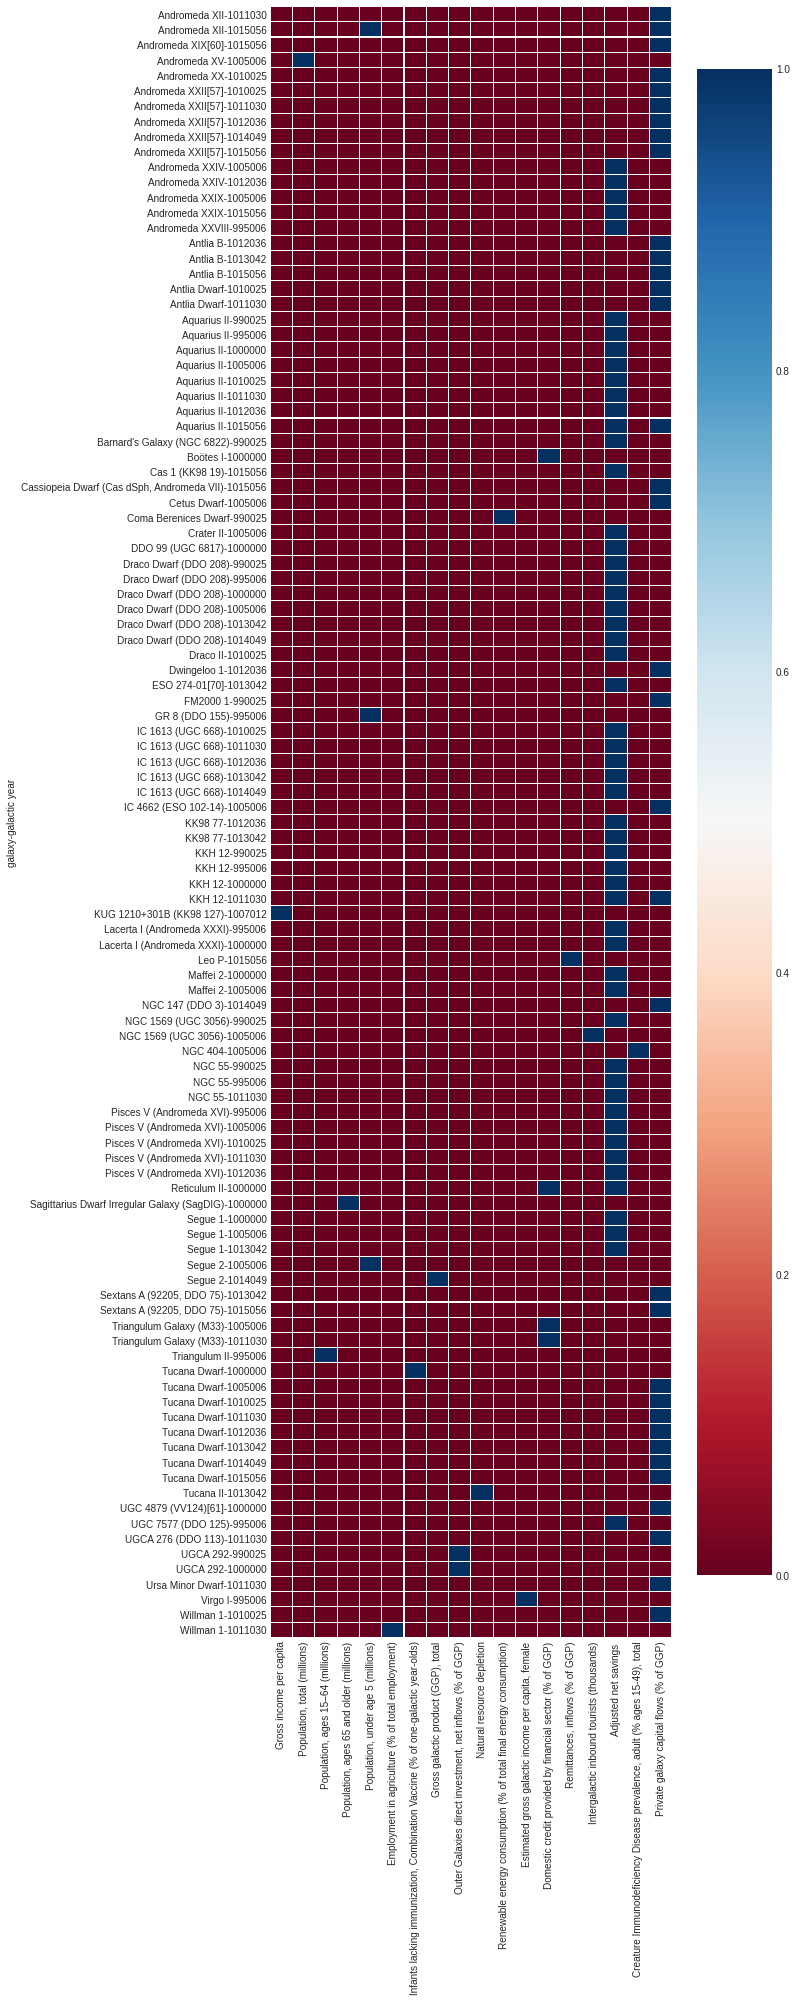

In [6]:
rcParams['figure.figsize'] = 9, 30
data_train_subzero_cols = [x for x in data_train.columns if \
                           (data_train[x].dtype in ['float32', 'int64'] and data_train[x].min() < 0)]
data_train_subzero = data_train[(data_train.drop('galaxy', axis=1) < 0).any(axis=1)][['galaxy', 'galactic year'] + data_train_subzero_cols]
sns.heatmap(data_train_subzero.set_index(['galaxy', 'galactic year']).sort_index() < 0, cmap="RdBu", linewidths=0.05)
display(data_train[data_train_subzero_cols].describe(include='all'))

In [ ]:
rcParams['figure.figsize'] = 18,36

fig = plt.figure()

for i, c in enumerate(data_train_subzero_cols):
    sns.scatterplot(x=data_train[data_train[c] < 0][c], y=data_train['y'], ax=fig.add_subplot(10,3,i+1), )
    sns.scatterplot(x=data_train[data_train[c] >= 0][c], y=data_train['y'],  )
plt.show()


In [ ]:
drop_sub0_columns = ['Adjusted net savings ', 'Private galaxy capital flows (% of GGP)']

In [ ]:
rcParams['figure.figsize'] = 6, 12
data_test_subzero_cols = [x for x in data_test.columns if \
                           (data_test[x].dtype in ['float64', 'int64'] and x != 'y' and data_test[x].min() < 0)]
data_test_subzero = data_test[(data_test.drop(['galaxy', 'y'], axis=1) < 0).any(axis=1)][['galaxy', 'galactic year'] + data_test_subzero_cols]
sns.heatmap(data_test_subzero.set_index(['galaxy', 'galactic year']).sort_index() < 0, cmap="RdBu", linewidths=0.05)
display(data_test[data_test_subzero_cols].describe(include='all'))

In [ ]:
rcParams['figure.figsize'] = 18,18

fig = plt.figure()

for i, c in enumerate(data_test_subzero_cols):
    sns.scatterplot(x=data_test[data_test[c] < 0][c], y=data_test['y'], ax=fig.add_subplot(10,3,i+1), )
    sns.scatterplot(x=data_test[data_test[c] >= 0][c], y=data_test['y'],  )
plt.show()


### Fill NaN

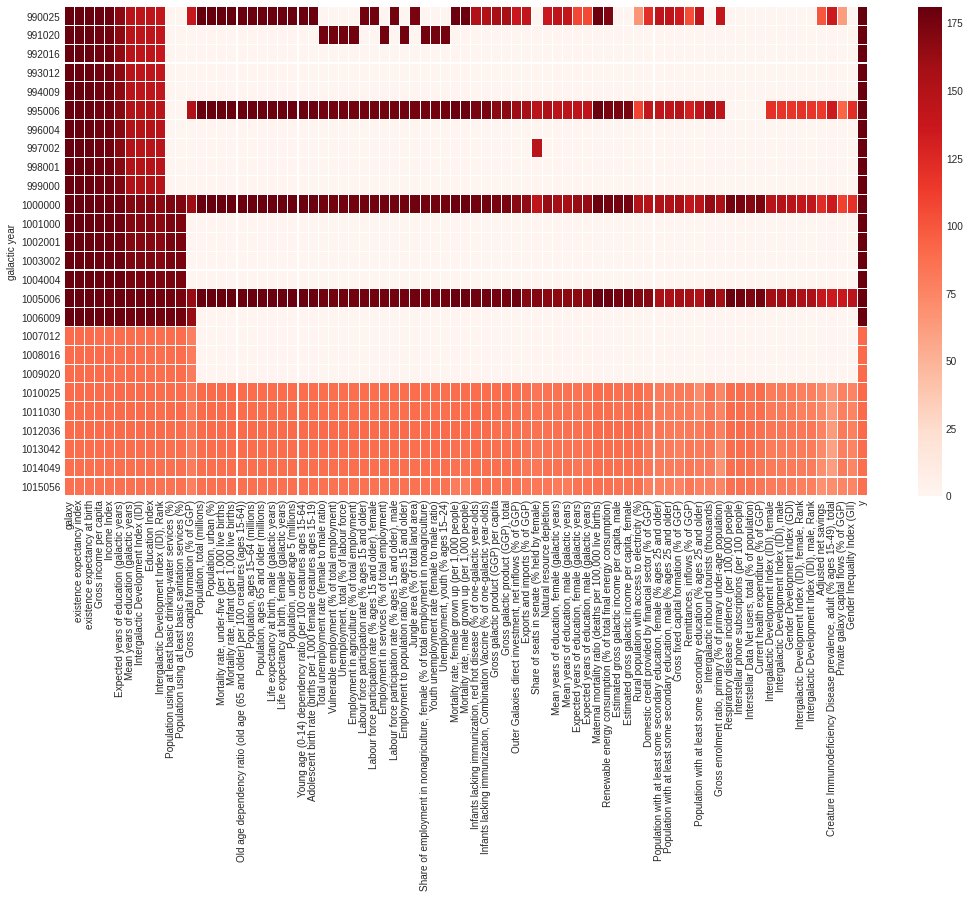

In [8]:
# Кол-во стран с незаполненными атрибутами по года
data = data_all.loc['train']
rcParams['figure.figsize'] = 18, 9

cols_nan = [x for x in data.columns if any((data[x] == data[x])) and x != 'galactic year']
sns.heatmap((data[['galactic year']].join(data[cols_nan] == data[cols_nan])).groupby('galactic year').sum(),
           cmap="Reds", linewidths=0.05);

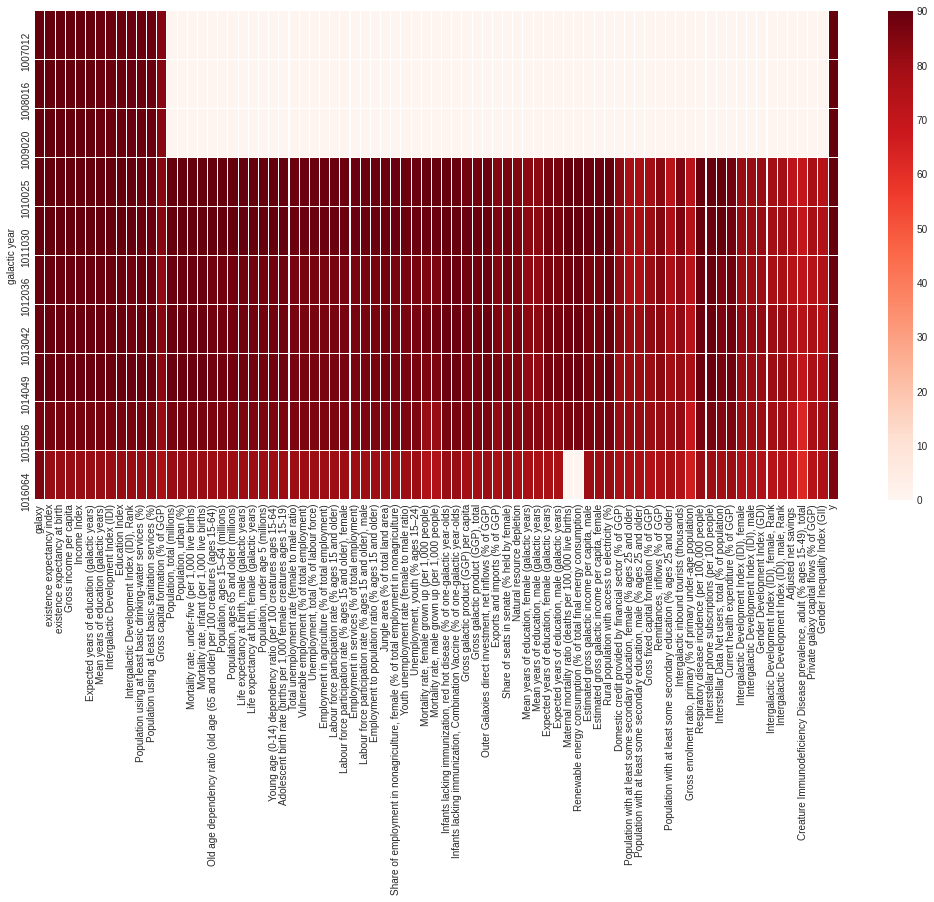

In [9]:
# Кол-во стран с незаполненными атрибутами по года
data = data_all.loc['test']
rcParams['figure.figsize'] = 18, 9

cols_nan = [x for x in data.columns if any((data[x] == data[x])) and x != 'galactic year']
sns.heatmap((data[['galactic year']].join(data[cols_nan] == data[cols_nan])).groupby('galactic year').sum(),
           cmap="Reds", linewidths=0.05);

Периоды с незаполненными признаками заполняем методом ffill.

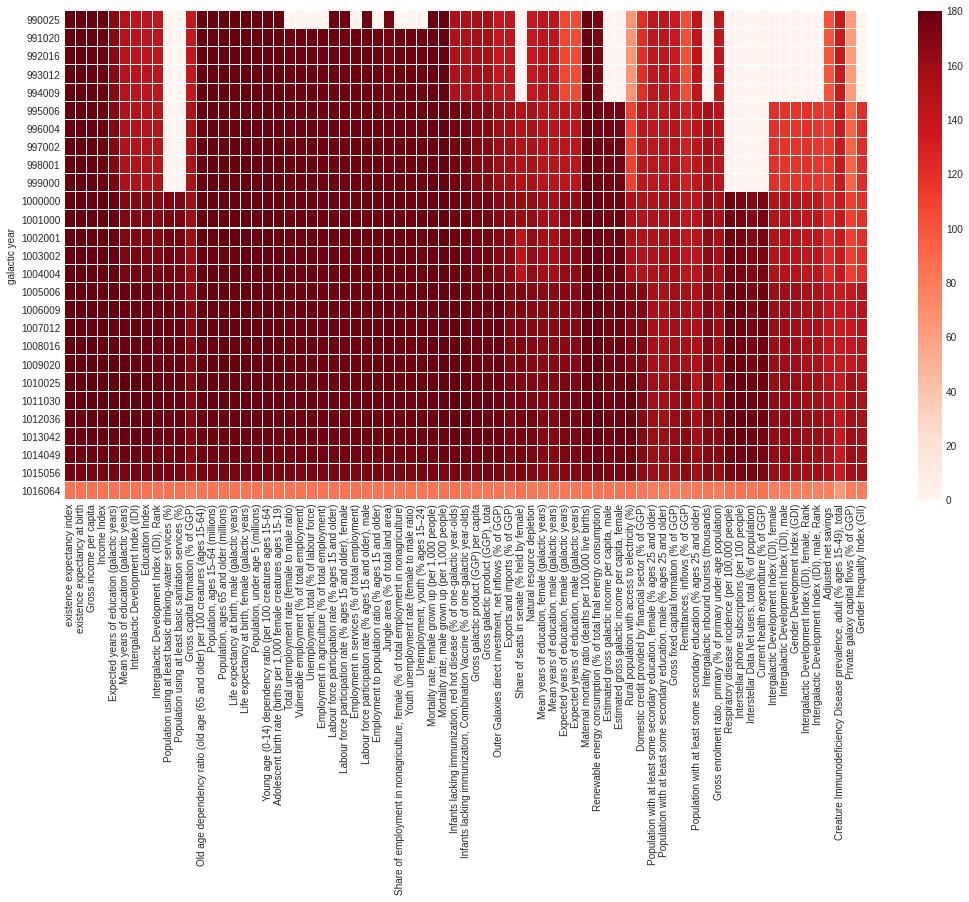

In [6]:
data_all = data_all.sort_values(['galaxy', 'galactic year']).groupby('galaxy', as_index=False).fillna(method='ffill', limit=4)
data = data_all

rcParams['figure.figsize'] = 18, 9

cols_nan = [x for x in data.columns if data[x].isnull().any() and x != 'galactic year']
sns.heatmap((data[['galactic year']].join(data[cols_nan].notna())).groupby('galactic year').sum(),
           cmap="Reds", linewidths=0.05);
plt.show()

## Изучение **y**

             y        y        y
count 3,865.00 3,865.00 3,865.00
mean      0.08     0.08     0.20
std       0.06     0.05     0.03
min       0.01     0.01     0.11
25%       0.05     0.05     0.18
50%       0.06     0.06     0.20
75%       0.09     0.08     0.21
max       0.68     0.52     0.30


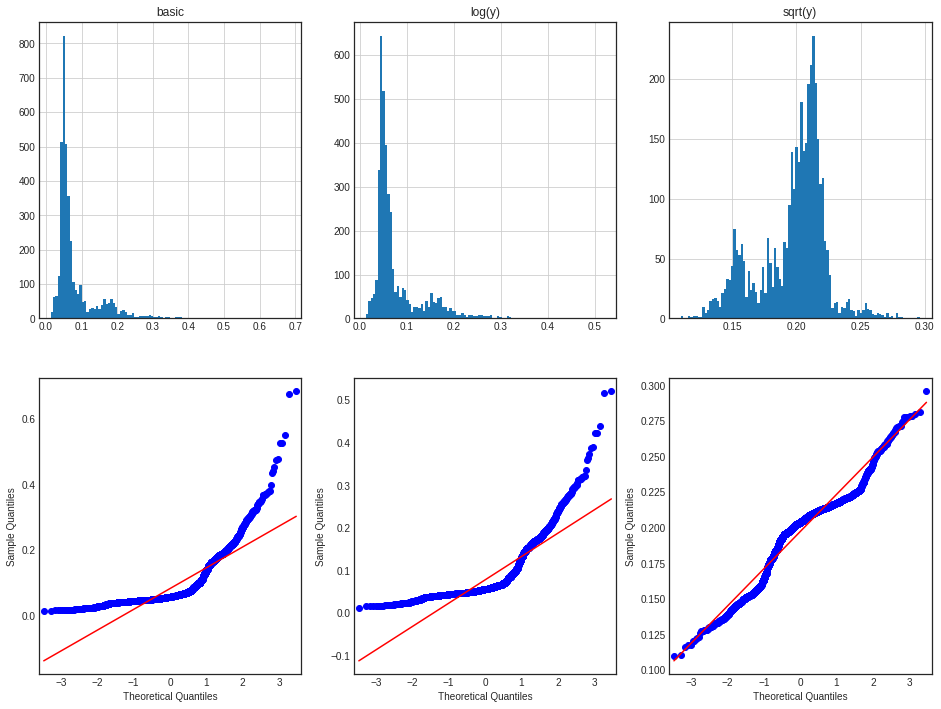

In [11]:
fig, ax = plt.subplots(2,3,figsize=(16,12))

desc_y = data_train['y'].describe()
ax[0,0].set_title('basic')
data_train['y'].hist(bins=100, ax=ax[0,0]);
qqplot(data_train['y'], ax=ax[1,0], line='s', fit=False);

log_y = np.log1p(data_train['y'])
ax[0,1].set_title('log(y)')
log_y.hist(bins=100, ax=ax[0,1]);
qqplot(log_y, ax=ax[1,1], line='s')
desc_y = pd.concat([desc_y, log_y.describe()], axis=1)

root_y = data_train['y'] ** (-1/4) / 10
ax[0,2].set_title('sqrt(y)')
root_y.hist(bins=100, ax=ax[0,2]);
qqplot(root_y, ax=ax[1,2], line='s')
desc_y = pd.concat([desc_y, root_y.describe()], axis=1)
print(desc_y)

plt.show()

-0.5765749460838396


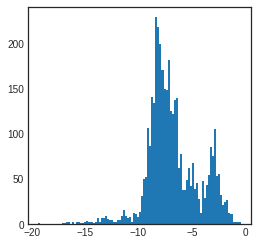

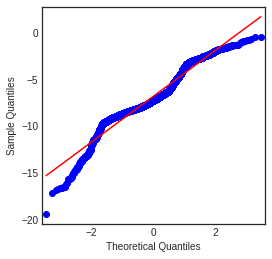

In [13]:
import scipy
data_boxcox, p = scipy.stats.boxcox(data_train['y'])
data_boxcox
rcParams['figure.figsize'] = 4, 4
plt.hist(data_boxcox, bins=100);
qqplot(data_boxcox, line='s');
print(p)

Значения **y** по годам и галактикам:

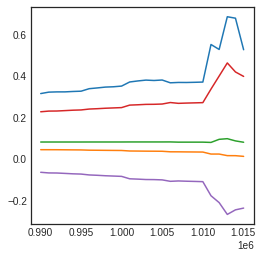

min  mean  max  std
galactic year                     
990025        0.05  0.08 0.31 0.05
991020        0.05  0.08 0.32 0.05
992016        0.04  0.08 0.32 0.05
993012        0.04  0.08 0.32 0.05
994009        0.04  0.08 0.32 0.05
995006        0.04  0.08 0.33 0.05
996004        0.04  0.08 0.34 0.05
997002        0.04  0.08 0.34 0.05
998001        0.04  0.08 0.35 0.05
999000        0.04  0.08 0.35 0.05
1000000       0.04  0.08 0.35 0.06
1001000       0.04  0.08 0.37 0.06
1002001       0.04  0.08 0.38 0.06
1003002       0.04  0.08 0.38 0.06
1004004       0.04  0.08 0.38 0.06
1005006       0.04  0.08 0.38 0.06
1006009       0.03  0.08 0.37 0.06
1007012       0.03  0.08 0.37 0.06
1008016       0.03  0.08 0.37 0.06
1009020       0.03  0.08 0.37 0.06
1010025       0.03  0.08 0.37 0.06
1011030       0.02  0.08 0.55 0.09
1012036       0.02  0.09 0.53 0.10
1013042       0.02  0.10 0.68 0.12
1014049       0.02  0.09 0.68 0.11
1015056       0.01  0.08 0.53 0.11

In [14]:
d = data_train.groupby('galactic year')['y'].agg(['min', 'mean', 'max', 'std']).sort_index()
sns.lineplot(data=d['max']);
sns.lineplot(data=d['min']);
sns.lineplot(data=d['mean']);
sns.lineplot(data=d['mean'] + 3*d['std']);
sns.lineplot(data=d['mean'] - 3*d['std']);
plt.show()
display(d)

In [15]:
data_train.groupby('galaxy')['y'].agg(['min', 'mean', 'max', 'std']).sort_values(by='std', ascending=False)

min  mean  max  std
galaxy                                                          
Cetus Dwarf                                 0.31  0.39 0.68 0.10
Tucana Dwarf                                0.15  0.21 0.53 0.09
ESO 294-010                                 0.25  0.30 0.47 0.07
MB 3                                        0.16  0.19 0.36 0.05
NGC 3741                                    0.27  0.31 0.48 0.05
Leo P                                       0.18  0.21 0.32 0.04
Leo T Dwarf                                 0.22  0.25 0.40 0.04
Canes Venatici II Dwarf                     0.19  0.22 0.32 0.04
IC 10 (UGC 192)                             0.17  0.21 0.30 0.04
Triangulum II                               0.18  0.20 0.29 0.03
Andromeda V                                 0.21  0.23 0.35 0.03
Andromeda IX                                0.15  0.17 0.29 0.03
Maffei 1                                    0.21  0.23 0.32 0.03
Leo IV Dwarf                                0.20  0.23 0.29 0.03
Cassiopeia Dwarf (Cas dSph, Andromeda VII)  0.15  0.18 0.27 0.03
KK98 35                                     0.20  0.23 0.30 0.02
Andromeda XV                                0.14  0.15 0.21 0.02
Pictor II                                   0.17  0.19 0.24 0.02
Segue 2                                     0.03  0.08 0.09 0.02
Canes Venatici I Dwarf                      0.10  0.11 0.17 0.02
Pegasus Dwarf Sph (And VI)                  0.13  0.14 0.18 0.02
Phoenix Dwarf Galaxy (P 6830)               0.17  0.19 0.23 0.01
Andromeda XIX[60]                           0.14  0.15 0.19 0.01
Fornax Dwarf (E356-G04)                     0.15  0.17 0.21 0.01
Andromeda II                                0.14  0.18 0.19 0.01
Reticulum II                                0.06  0.11 0.12 0.01
NGC 5102                                    0.14  0.16 0.18 0.01
MB 1 (KK98 21)                              0.13  0.14 0.17 0.01
IC 3104                                     0.01  0.04 0.05 0.01
Andromeda XVII                              0.02  0.06 0.07 0.01
KKR 25                                      0.02  0.04 0.05 0.01
Eridanus II                                 0.04  0.06 0.07 0.01
Donatiello I                                0.15  0.17 0.18 0.01
Boötes II                                   0.07  0.10 0.10 0.01
NGC 5237                                    0.10  0.12 0.13 0.01
Antlia 2                                    0.10  0.11 0.14 0.01
KKh 060                                     0.02  0.04 0.05 0.01
UGCA 438 (ESO 407-018)                      0.04  0.07 0.07 0.01
KKs 3                                       0.02  0.05 0.05 0.01
Reticulum III                               0.02  0.04 0.05 0.01
Antlia B                                    0.02  0.04 0.05 0.01
Andromeda XXIV                              0.02  0.04 0.05 0.01
Andromeda VIII                              0.02  0.04 0.05 0.01
UGC 8651 (DDO 181)                          0.02  0.04 0.05 0.01
KKH 12                                      0.02  0.04 0.05 0.01
Pegasus III                                 0.02  0.04 0.05 0.01
UGCA 15 (DDO 6)                             0.02  0.05 0.05 0.01
UGC 4483                                    0.02  0.04 0.05 0.01
Segue 1                                     0.02  0.04 0.05 0.01
UGCA 276 (DDO 113)                          0.02  0.04 0.05 0.01
NGC 5206                                    0.02  0.04 0.05 0.01
HIPASS J1247-77                             0.04  0.06 0.07 0.01
Crater II                                   0.02  0.04 0.05 0.01
IC 5152                                     0.03  0.05 0.06 0.01
Cetus III                                   0.02  0.04 0.05 0.01
Horologium II                               0.02  0.04 0.05 0.01
Triangulum Galaxy (M33)                     0.03  0.05 0.05 0.01
Sextans A (92205, DDO 75)                   0.10  0.11 0.14 0.01
Coma Berenices Dwarf                        0.10  0.10 0.13 0.01
Andromeda XI                                0.02  0.04 0.05 0.01
NGC 247        

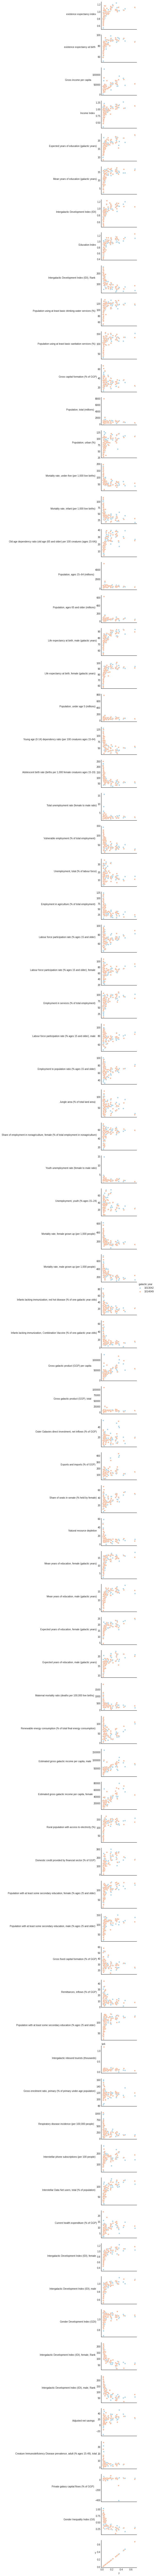

In [16]:
data = data_train.loc[data_train['galactic year'].isin([1013042, 1014049])]
g = sns.pairplot(data, x_vars=['y'], y_vars=data.columns[2:], hue='galactic year', palette='RdBu_r')

for ax in g.axes.flatten():
    
    ax.yaxis.get_label().set_rotation(0)
    ax.yaxis.get_label().set_horizontalalignment('right')

In [ ]:
corr_cols_years = data.corr().columns[data.corr()['y'] > 0.5]

In [ ]:
data = data_train.loc[data_train['galaxy'].isin(['Cetus Dwarf', 'Tucana Dwarf'])]
g = sns.pairplot(data, x_vars=['y'], y_vars=data_corr.columns[2:], hue='galaxy', palette='RdBu_r')

for ax in g.axes.flatten():
    ax.yaxis.get_label().set_rotation(0)
    ax.yaxis.get_label().set_horizontalalignment('right')

In [ ]:
corr_cols_galaxy = data.corr().columns[data.corr()['y'] > 0.5]

In [ ]:
corr_cols = list(corr_cols_galaxy.intersection(corr_cols_years))
corr_cols.remove('y')
corr_cols

## Features

### Функция для анализа данных

In [7]:
def show_hist(data, cols):
    """Hstograms"""
    print('Data distribution:', '\n')
    for i, c in enumerate(cols):
        if i % 3 == 0:
            if i > 0:
                plt.tight_layout()
                plt.show()
                plt.close()
            fig = plt.figure(figsize=(12,3));
        data_wrk = data[c]
        sns.distplot(data_wrk, bins=50, ax=fig.add_subplot(1, 3, (i % 3) + 1),);
        fig.axes[-1].set_title('\n'.join(wrap(c, 30)))
    plt.tight_layout()
    plt.show(1)
    plt.close(1)

def show_qqplot(data, cols):
    """Q-Q plot"""
    print('Q-Q Plot:', '\n')
    for i, c in enumerate(cols):
        if i % 3 == 0:
            if i > 0:
                plt.tight_layout()
                plt.show()
                plt.close()
            fig = plt.figure(figsize=(12,3));
        data_wrk = data[c]
        qqplot(data_wrk, ax=fig.add_subplot(1, 3, (i % 3) + 1),);
        fig.axes[-1].set_title('\n'.join(wrap(c, 30)))
    plt.tight_layout()    
    plt.show()
    plt.close()
    
def show_scatter(data, cols):
    """Scatter"""
    print('XY:', '\n')
    for i, c in enumerate(cols):
        if i % 3 == 0:
            if i > 0:
                plt.tight_layout()
                plt.show()
                plt.close()
            fig = plt.figure(figsize=(12,3));
        data_wrk = data[c]
        sns.scatterplot(data=data, x=c, y=data['y'], ax=fig.add_subplot(1, 3, (i % 3) + 1),);
        fig.axes[-1].set_title('\n'.join(wrap(c, 30)))
        fig.axes[-1].set_xlabel(None);
    plt.tight_layout()
    plt.show()
    plt.close()    
    
def show_xy(data, cols):
    """Lineplot"""
    print('By year:', '\n')
    for i, c in enumerate(cols):
        if i % 3 == 0:
            if i > 0:
                plt.tight_layout()
                plt.show()
                plt.close()
            fig = plt.figure(figsize=(12,3));        
        data_wrk = data_train.groupby('galactic year')[c].\
                     agg(['min', 'mean', 'max', 'std']).sort_index()
        data_wrk['min_std'] = data_wrk['mean'] - 3 * data_wrk['std'] 
        data_wrk['max_std'] = data_wrk['mean'] + 3 * data_wrk['std'] 
        data_wrk = data_wrk[['min', 'max', 'mean', 'min_std', 'max_std']]
        sns.lineplot(data=data_wrk, ax=fig.add_subplot(1, 3, (i % 3) + 1),);
        fig.axes[-1].set_title('\n'.join(wrap(c, 30)))
    plt.tight_layout()
    plt.show()
    plt.close()

def show_nans(data, cols):
    """NaNs by years"""
    print('NaNs:', '\n')
    for i, c in enumerate(cols):
        if i % 3 == 0:
            if i > 0:
                plt.tight_layout()
                plt.show()
                plt.close()
            fig = plt.figure(figsize=(12,3));
        if c != 'y':
            data_wrk1 = data_train.groupby('galactic year')[c].count() / data_train.groupby('galactic year')[c].size()
            sns.lineplot(data=data_wrk1, ax=fig.add_subplot(1, 3, (i % 3) + 1),);
            data_wrk2 = data_test.groupby('galactic year')[c].count() / data_test.groupby('galactic year')[c].size()
            sns.lineplot(data=data_wrk2, ax=fig.add_subplot(1, 3, (i % 3) + 1),);
            fig.axes[-1].set_title('\n'.join(wrap(c, 30)))
    plt.tight_layout()
    plt.show()
    plt.close()
    
def show_box(data, cols):
    """Boxplot"""
    print('Box:', '\n')
    for i, c in enumerate(cols):
        if i % 3 == 0:
            if i > 0:
                plt.tight_layout()
                plt.show()
                plt.close()
            fig = plt.figure(figsize=(12,3));
        if c != 'y':
            sns.boxplot(data=[data_train[c], data_test[c]], ax=fig.add_subplot(1, 3, (i % 3) + 1),);
            fig.axes[-1].set_title('\n'.join(wrap(c, 30)))
    plt.tight_layout()
    plt.show()
    plt.close()
    
def data_desc(data, cols=[], start_col=0, n_cols=11):
    """Description for data
    data - Dataset;
    cols - Columns for subset;
    start_col - Start No. of column subset;
    n_cols - Number of columns in subset. Default 10 for good screen fitting;
    """
    cols = cols.copy()
    if not cols:
        i = start_col
        cols = list(data.drop(['galaxy', 'galactic year', 'y'], axis=1).columns[start_col:min(data.shape[1], start_col + n_cols)])
    cols.append('y')
#    print('Data head:', '\n')
#    display(data[cols].head(10))

#    print('Data description:', '\n')
#    display(data[cols].describe(include='all'))
    
#    show_hist(data, cols)
    
#    show_qqplot(data, cols)

    show_scatter(data, cols)

    show_xy(data, cols)

    show_box(data, cols)
    
    show_nans(data, cols)
    
    print('Data correlation:', '\n')
    display(pd.concat([data[cols].corrwith(data['y'], method='pearson'), 
                       data[cols].corrwith(data['y'], method='kendall'), 
                       data[cols].corrwith(data['y'], method='spearman'),
                       data[cols].skew(axis=0)], axis=1, keys=['pearson', 'kendall', 'spearman', 'skew']))
    cols.remove('y')
    return cols

### Признаки

In [8]:
features_with_outliers = []
features_drop = []
features_new = []

In [9]:
data_train = data_all.loc['train']
data_test = data_all.loc['test']

#### Группа 1:

XY: 



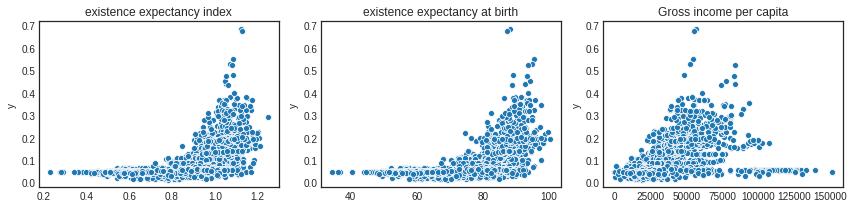

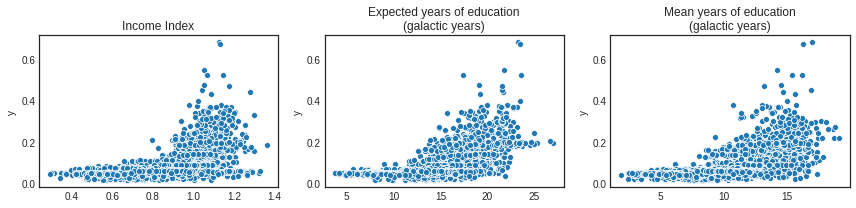

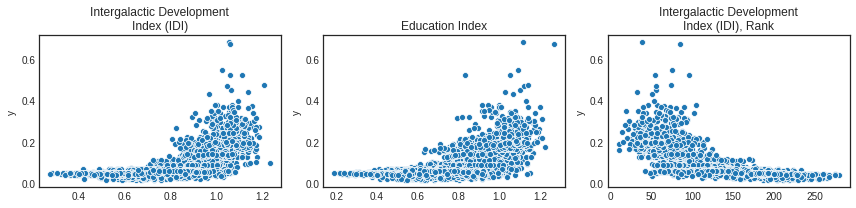

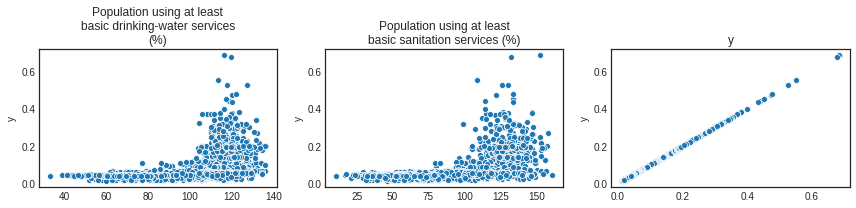

By year: 



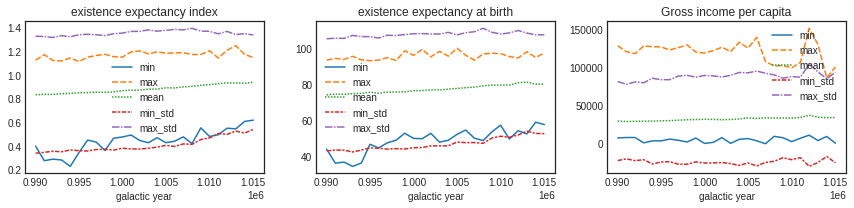

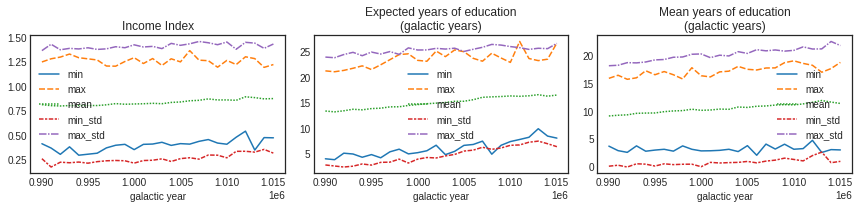

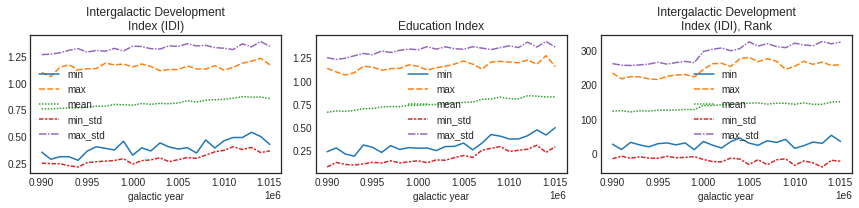

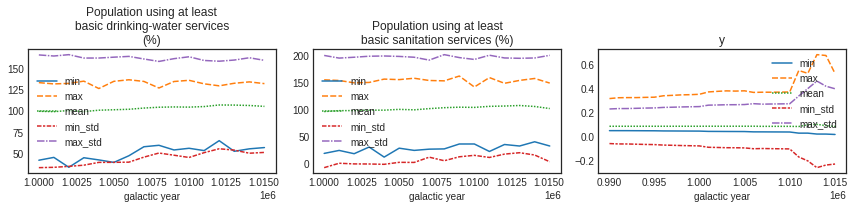

Box: 



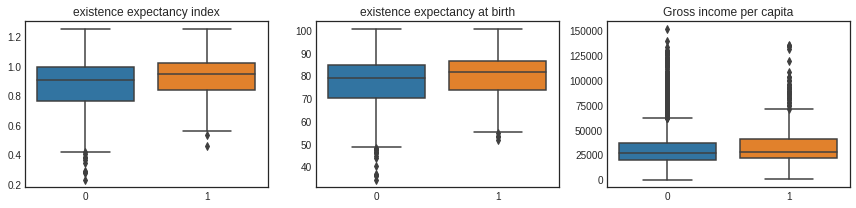

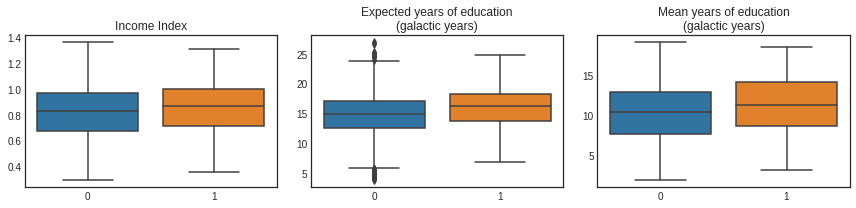

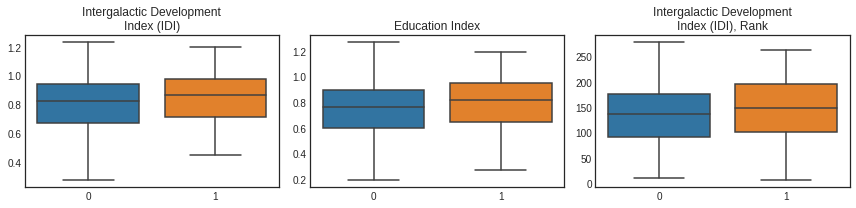

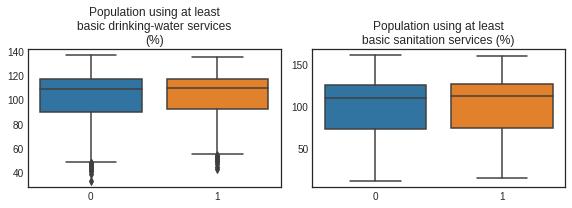

NaNs: 



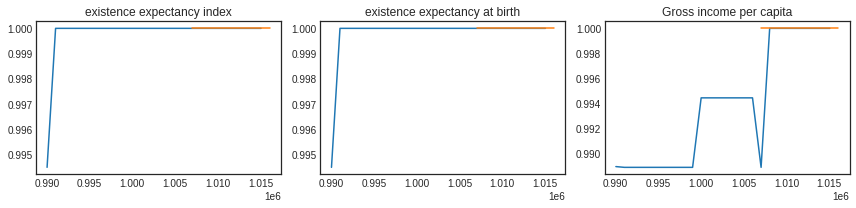

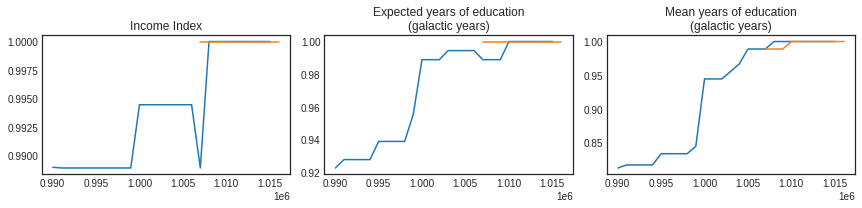

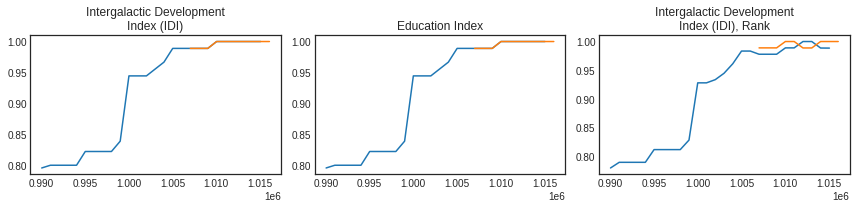

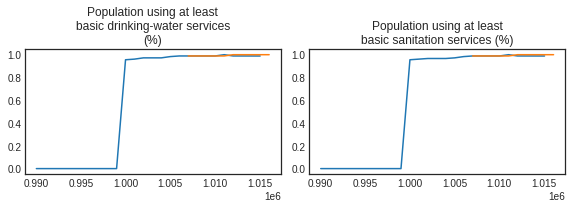

Data correlation: 



pearson  kendall  \
existence expectancy index                             0.55     0.51   
existence expectancy at birth                          0.56     0.52   
Gross income per capita                                0.51     0.40   
Income Index                                           0.58     0.48   
Expected years of education (galactic years)           0.58     0.46   
Mean years of education (galactic years)               0.58     0.49   
Intergalactic Development Index (IDI)                  0.63     0.54   
Education Index                                        0.61     0.50   
Intergalactic Development Index (IDI), Rank           -0.68    -0.64   
Population using at least basic drinking-water ...     0.43     0.44   
Population using at least basic sanitation serv...     0.48     0.47   
y                                                      1.00     1.00   

                                                    spearman  skew  
existence expectancy index                              0.71 -0.62  
existence expectancy at birth                           0.72 -0.63  
Gross income per capita                                 0.56  2.11  
Income Index                                            0.65  0.00  
Expected years of education (galactic years)            0.64 -0.23  
Mean years of education (galactic years)                0.68 -0.06  
Intergalactic Development Index (IDI)                   0.74 -0.30  
Education Index                                         0.69 -0.17  
Intergalactic Development Index (IDI), Rank            -0.82  0.06  
Population using at least basic drinking-water ...      0.63 -0.93  
Population using at least basic sanitation serv...      0.66 -0.58  
y                                                       1.00  2.66

['existence expectancy index',
 'existence expectancy at birth',
 'Gross income per capita',
 'Income Index',
 'Expected years of education (galactic years)',
 'Mean years of education (galactic years)',
 'Intergalactic Development Index (IDI)',
 'Education Index',
 'Intergalactic Development Index (IDI), Rank',
 'Population using at least basic drinking-water services (%)',
 'Population using at least basic sanitation services (%)']

In [9]:
data_desc(data_train, start_col=0)

In [10]:
data_all['Years of education ratio'] = data_all['Mean years of education (galactic years)'] / data_all['Expected years of education (galactic years)']
features_new += ['Years of education ratio']

#### Группа 2:

XY: 



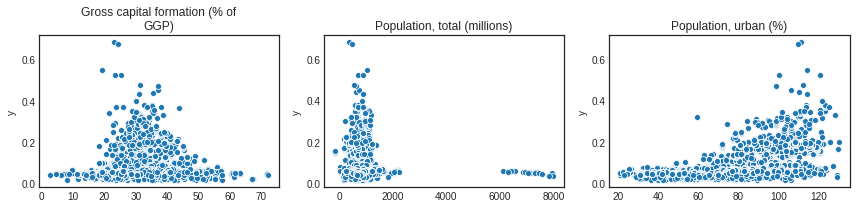

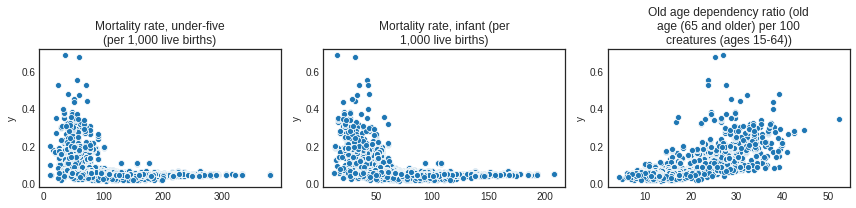

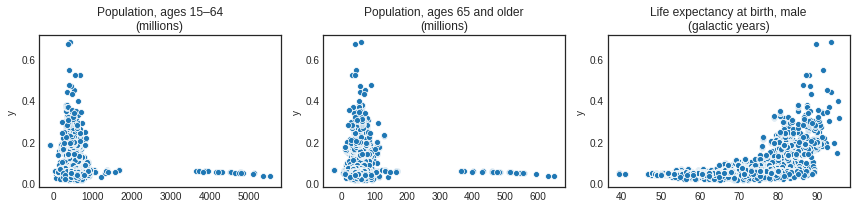

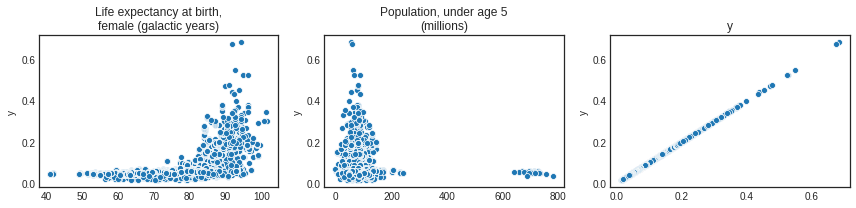

By year: 



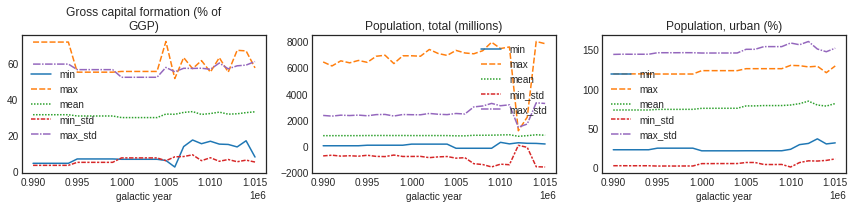

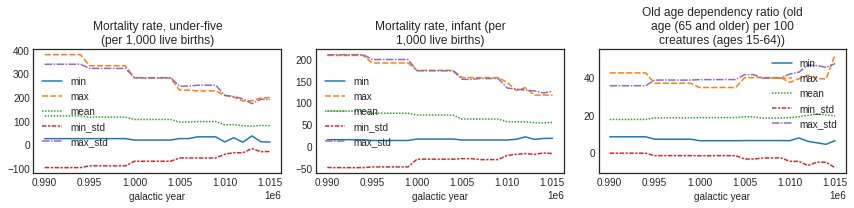

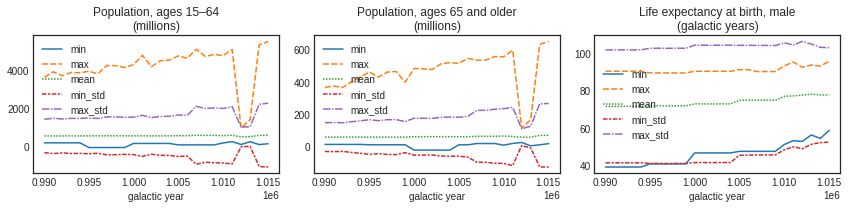

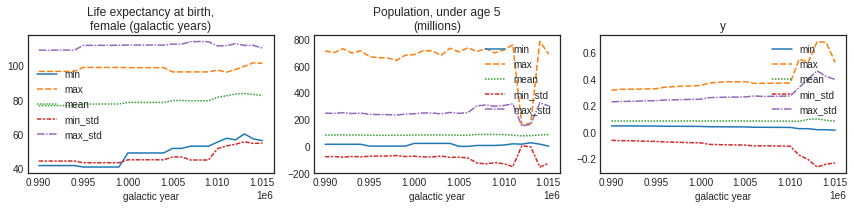

Box: 



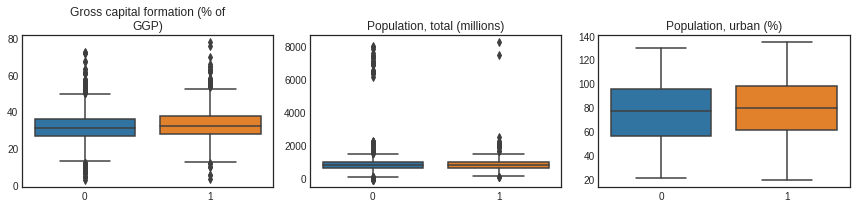

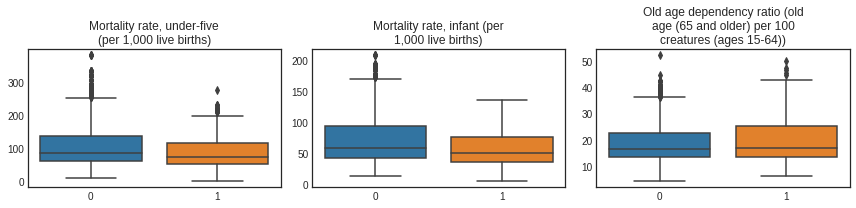

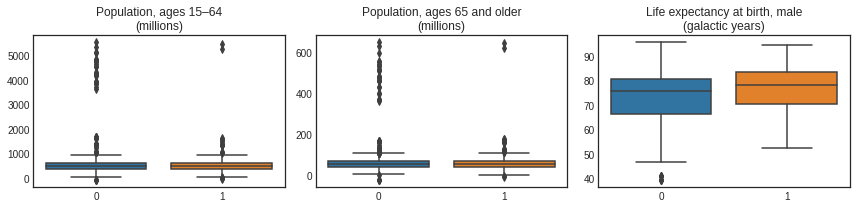

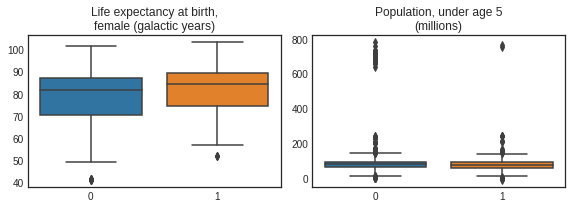

NaNs: 



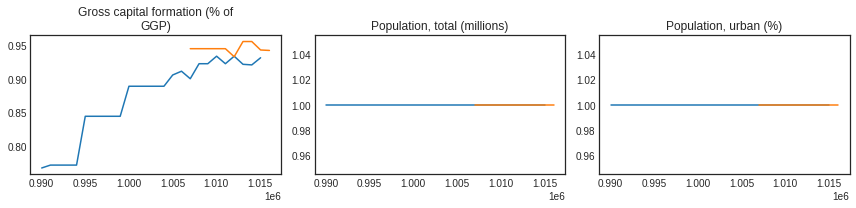

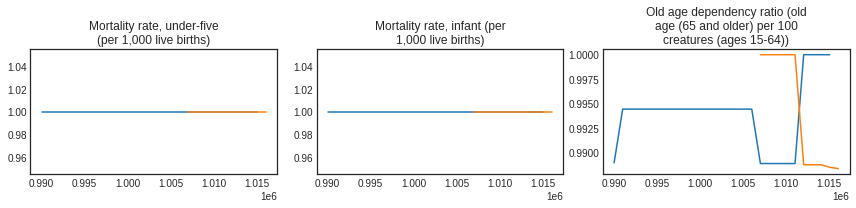

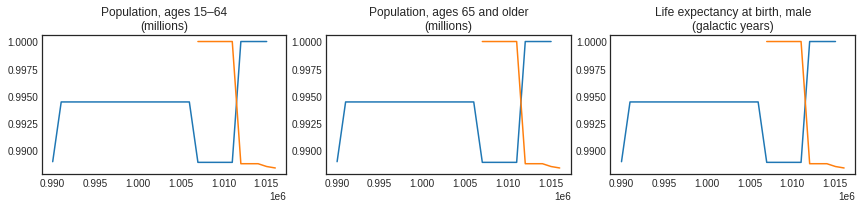

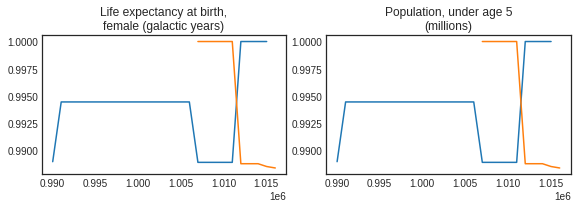

Data correlation: 



pearson  kendall  \
Gross capital formation (% of GGP)                     0.07     0.11   
Population, total (millions)                          -0.05     0.01   
Population, urban (%)                                  0.50     0.39   
Mortality rate, under-five (per 1,000 live births)    -0.44    -0.47   
Mortality rate, infant (per 1,000 live births)        -0.49    -0.49   
Old age dependency ratio (old age (65 and older...     0.71     0.49   
Population, ages 15–64 (millions)                     -0.06    -0.02   
Population, ages 65 and older (millions)              -0.03     0.01   
Life expectancy at birth, male (galactic years)        0.55     0.50   
Life expectancy at birth, female (galactic years)      0.55     0.55   
Population, under age 5 (millions)                    -0.05     0.00   
y                                                      1.00     1.00   

                                                    spearman  skew  
Gross capital formation (% of GGP)                      0.16  0.43  
Population, total (millions)                            0.02  8.34  
Population, urban (%)                                   0.57 -0.08  
Mortality rate, under-five (per 1,000 live births)     -0.67  1.24  
Mortality rate, infant (per 1,000 live births)         -0.68  0.97  
Old age dependency ratio (old age (65 and older...      0.68  0.92  
Population, ages 15–64 (millions)                      -0.03  8.64  
Population, ages 65 and older (millions)                0.02  8.63  
Life expectancy at birth, male (galactic years)         0.69 -0.59  
Life expectancy at birth, female (galactic years)       0.74 -0.64  
Population, under age 5 (millions)                      0.00  8.45  
y                                                       1.00  2.66

['Gross capital formation (% of GGP)',
 'Population, total (millions)',
 'Population, urban (%)',
 'Mortality rate, under-five (per 1,000 live births)',
 'Mortality rate, infant (per 1,000 live births)',
 'Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))',
 'Population, ages 15–64 (millions)',
 'Population, ages 65 and older (millions)',
 'Life expectancy at birth, male (galactic years)',
 'Life expectancy at birth, female (galactic years)',
 'Population, under age 5 (millions)']

In [48]:
data_desc(data_train, start_col=11)

In [11]:
data_all['Population, ages 15–64'] = data_all['Population, ages 15–64 (millions)'] / data_all['Population, total (millions)']
data_all['Population, ages 65 and older'] = data_all['Population, ages 65 and older (millions)'] / data_all['Population, total (millions)']
data_all['Population, under age 5'] = data_all['Population, under age 5 (millions)'] / data_all['Population, total (millions)']
data_all['Under 5 per 15-64'] = data_all['Population, under age 5 (millions)']/data_all['Population, ages 15–64 (millions)']

In [12]:
features_new += ['Population, ages 15–64', 'Population, ages 65 and older', 'Population, under age 5',
                 'Under 5 per 15-64']

In [13]:
features_drop += ['Population, total (millions)', 'Population, ages 15–64 (millions)',
                  'Population, ages 65 and older (millions)',  'Population, under age 5 (millions)']  
features_drop

['Population, total (millions)',
 'Population, ages 15–64 (millions)',
 'Population, ages 65 and older (millions)',
 'Population, under age 5 (millions)']

#### Группа 3:

XY: 



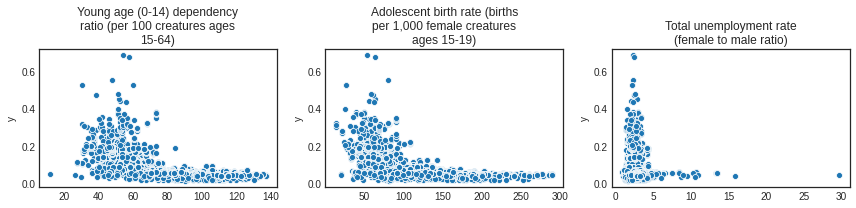

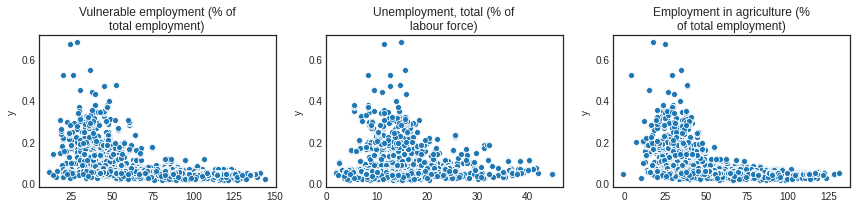

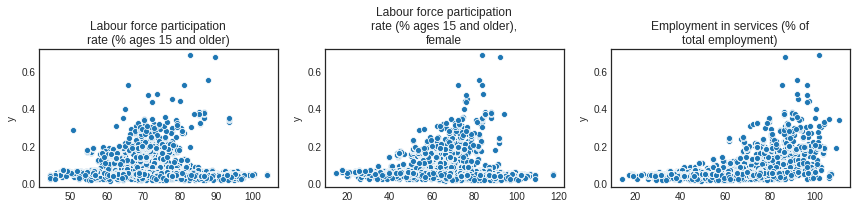

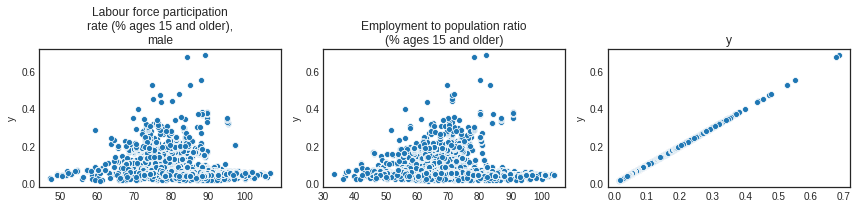

By year: 



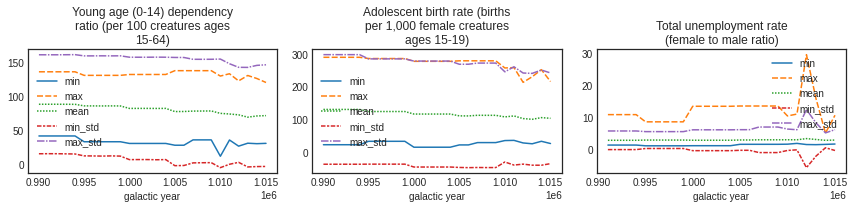

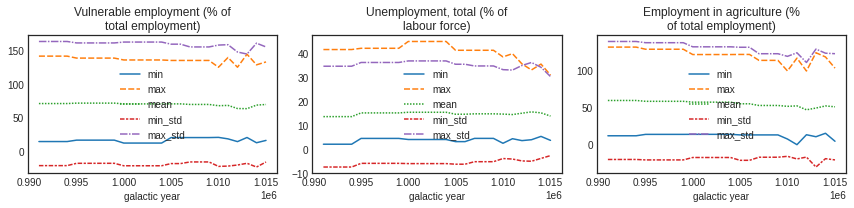

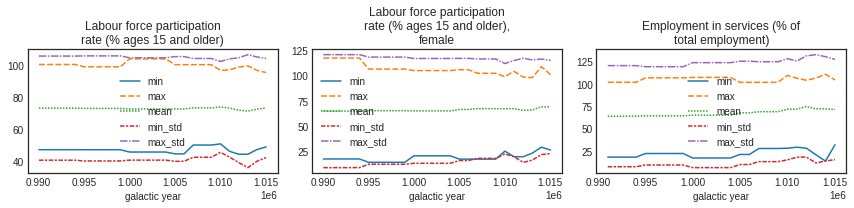

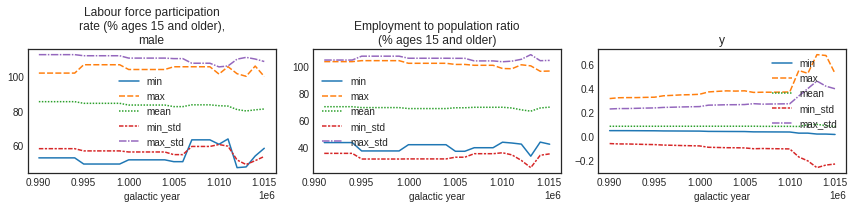

Box: 



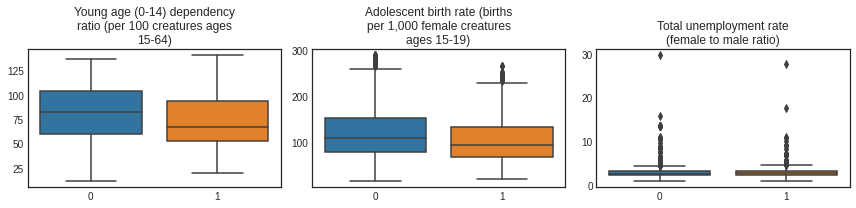

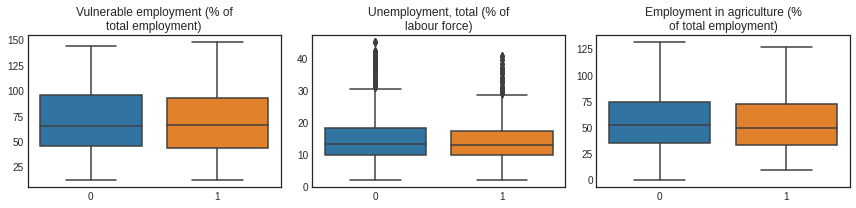

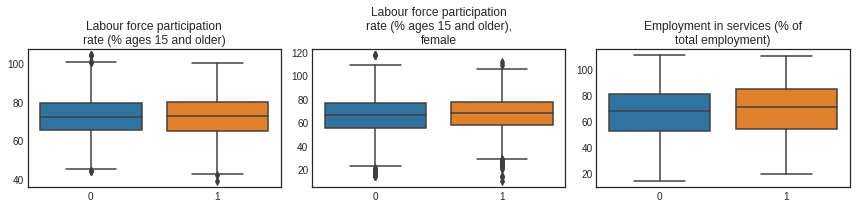

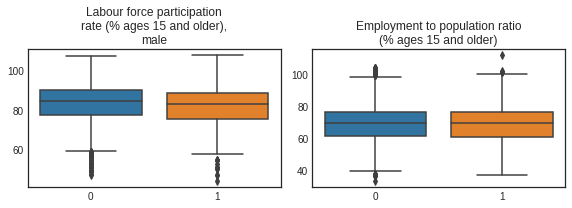

NaNs: 



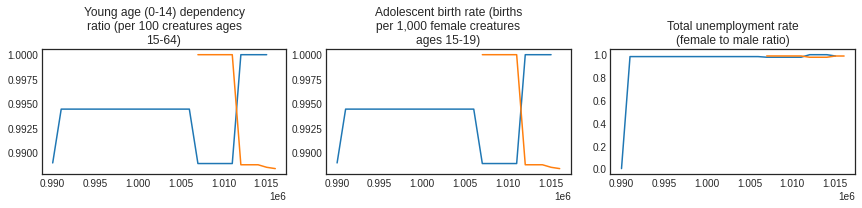

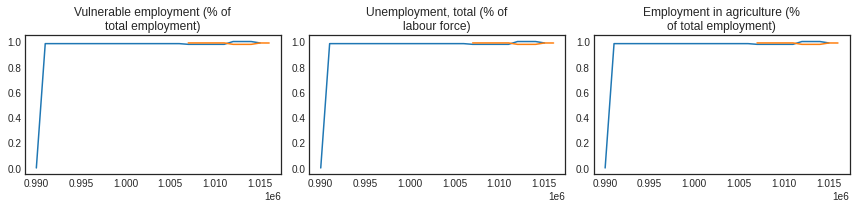

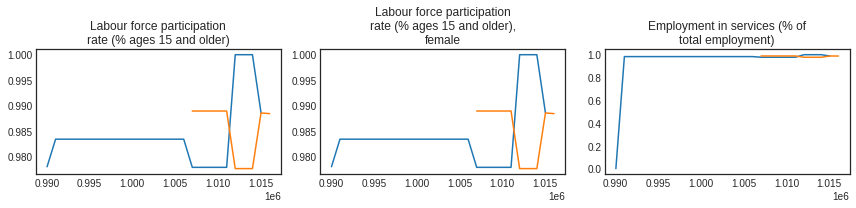

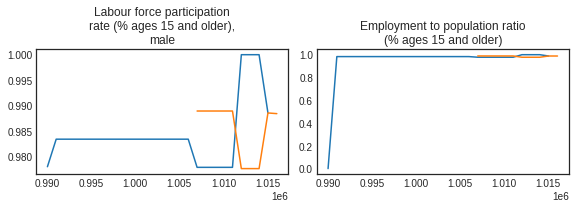

Data correlation: 



pearson  kendall  \
Young age (0-14) dependency ratio (per 100 crea...    -0.60    -0.53   
Adolescent birth rate (births per 1,000 female ...    -0.52    -0.46   
Total unemployment rate (female to male ratio)        -0.07    -0.01   
Vulnerable employment (% of total employment)         -0.51    -0.47   
Unemployment, total (% of labour force)               -0.04     0.06   
Employment in agriculture (% of total employment)     -0.51    -0.44   
Labour force participation rate (% ages 15 and ...    -0.08    -0.14   
Labour force participation rate (% ages 15 and ...     0.04    -0.07   
Employment in services (% of total employment)         0.50     0.40   
Labour force participation rate (% ages 15 and ...    -0.24    -0.21   
Employment to population ratio (% ages 15 and o...    -0.05    -0.11   
y                                                      1.00     1.00   

                                                    spearman  skew  
Young age (0-14) dependency ratio (per 100 crea...     -0.72  0.02  
Adolescent birth rate (births per 1,000 female ...     -0.64  0.71  
Total unemployment rate (female to male ratio)         -0.02  7.36  
Vulnerable employment (% of total employment)          -0.65  0.29  
Unemployment, total (% of labour force)                 0.09  1.34  
Employment in agriculture (% of total employment)      -0.62  0.47  
Labour force participation rate (% ages 15 and ...     -0.21  0.18  
Labour force participation rate (% ages 15 and ...     -0.13 -0.20  
Employment in services (% of total employment)          0.57 -0.20  
Labour force participation rate (% ages 15 and ...     -0.30 -0.38  
Employment to population ratio (% ages 15 and o...     -0.17  0.17  
y                                                       1.00  2.66

['Young age (0-14) dependency ratio (per 100 creatures ages 15-64)',
 'Adolescent birth rate (births per 1,000 female creatures ages 15-19)',
 'Total unemployment rate (female to male ratio)',
 'Vulnerable employment (% of total employment)',
 'Unemployment, total (% of labour force)',
 'Employment in agriculture (% of total employment)',
 'Labour force participation rate (% ages 15 and older)',
 'Labour force participation rate (% ages 15 and older), female',
 'Employment in services (% of total employment)',
 'Labour force participation rate (% ages 15 and older), male',
 'Employment to population ratio (% ages 15 and older)']

In [14]:
data_desc(data_train, start_col=22)

In [141]:
features_drop += []
features_drop

['Population, total (millions)',
 'Population, ages 15–64 (millions)',
 'Population, ages 65 and older (millions)',
 'Population, under age 5 (millions)',
 'Total unemployment rate (female to male ratio)']

In [14]:
features_with_outliers += ['Total unemployment rate (female to male ratio)']

#### Группа 4:

XY: 



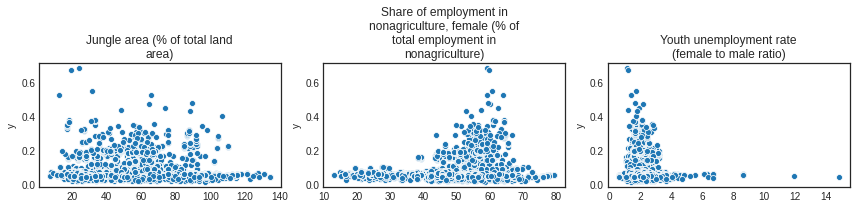

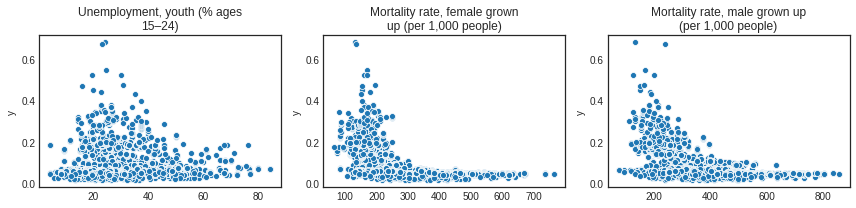

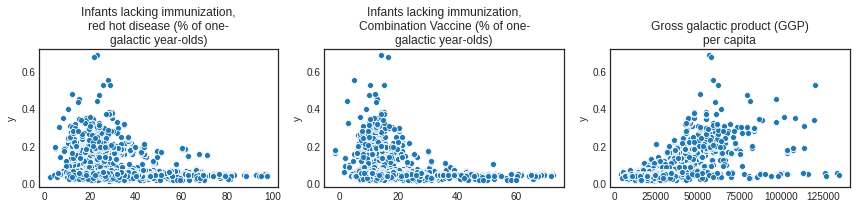

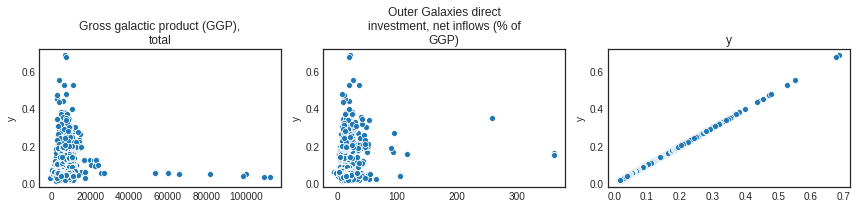

By year: 



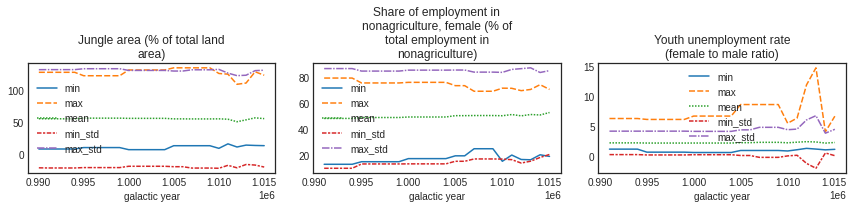

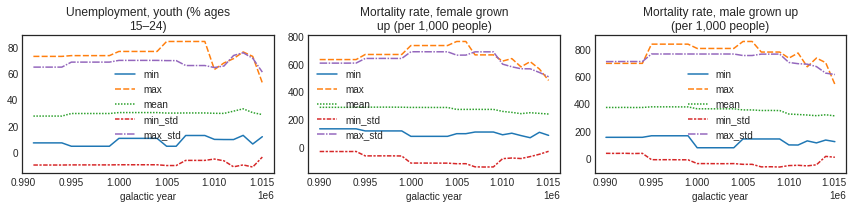

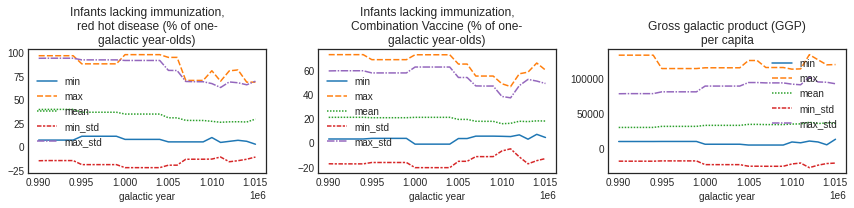

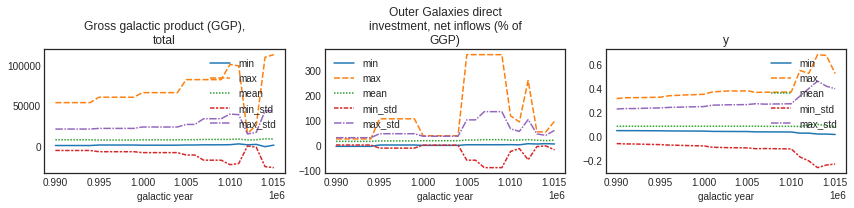

Box: 



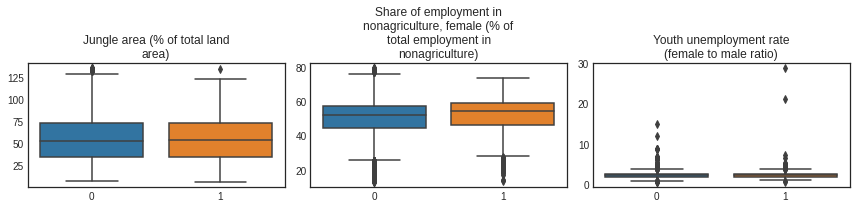

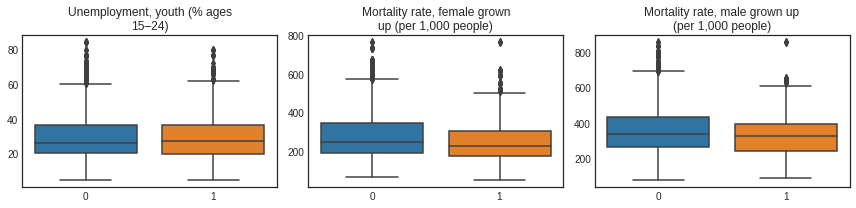

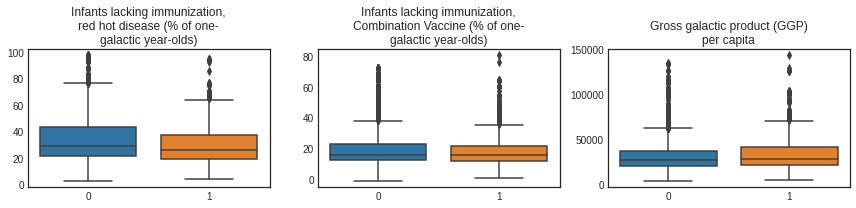

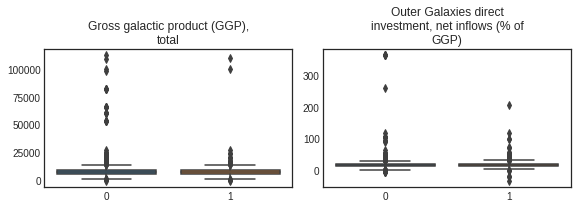

NaNs: 



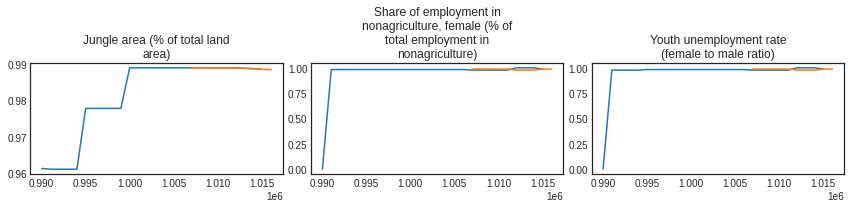

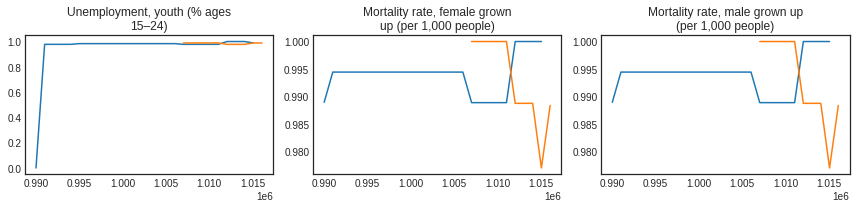

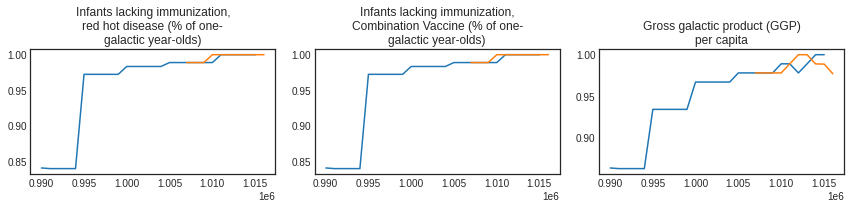

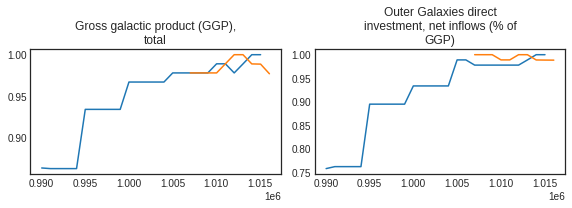

Data correlation: 



pearson  kendall  \
Jungle area (% of total land area)                    -0.01    -0.01   
Share of employment in nonagriculture, female (...     0.21     0.10   
Youth unemployment rate (female to male ratio)        -0.11    -0.02   
Unemployment, youth (% ages 15–24)                    -0.01     0.08   
Mortality rate, female grown up (per 1,000 people)    -0.48    -0.51   
Mortality rate, male grown up (per 1,000 people)      -0.48    -0.42   
Infants lacking immunization, red hot disease (...    -0.26    -0.25   
Infants lacking immunization, Combination Vacci...    -0.28    -0.27   
Gross galactic product (GGP) per capita                0.54     0.42   
Gross galactic product (GGP), total                    0.01     0.07   
Outer Galaxies direct investment, net inflows (...     0.09     0.02   
y                                                      1.00     1.00   

                                                    spearman  skew  
Jungle area (% of total land area)                     -0.01  0.44  
Share of employment in nonagriculture, female (...      0.15 -0.77  
Youth unemployment rate (female to male ratio)         -0.03  4.17  
Unemployment, youth (% ages 15–24)                      0.13  1.07  
Mortality rate, female grown up (per 1,000 people)     -0.70  1.11  
Mortality rate, male grown up (per 1,000 people)       -0.59  0.82  
Infants lacking immunization, red hot disease (...     -0.37  1.09  
Infants lacking immunization, Combination Vacci...     -0.39  1.98  
Gross galactic product (GGP) per capita                 0.58  2.09  
Gross galactic product (GGP), total                     0.11  9.84  
Outer Galaxies direct investment, net inflows (...      0.03 16.18  
y                                                       1.00  2.66

['Jungle area (% of total land area)',
 'Share of employment in nonagriculture, female (% of total employment in nonagriculture)',
 'Youth unemployment rate (female to male ratio)',
 'Unemployment, youth (% ages 15–24)',
 'Mortality rate, female grown up (per 1,000 people)',
 'Mortality rate, male grown up (per 1,000 people)',
 'Infants lacking immunization, red hot disease (% of one-galactic year-olds)',
 'Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)',
 'Gross galactic product (GGP) per capita',
 'Gross galactic product (GGP), total',
 'Outer Galaxies direct investment, net inflows (% of GGP)']

In [42]:
data_desc(data_train, start_col=33)

In [15]:
data_all['Mortality rate, grown up (per 1,000 people)'] = data_all['Mortality rate, female grown up (per 1,000 people)'] \
                                                        + data_all['Mortality rate, male grown up (per 1,000 people)']
features_new += ['Mortality rate, grown up (per 1,000 people)']

In [16]:
features_drop += ['Gross galactic product (GGP), total',]
features_drop

['Population, total (millions)',
 'Population, ages 15–64 (millions)',
 'Population, ages 65 and older (millions)',
 'Population, under age 5 (millions)',
 'Gross galactic product (GGP), total']

In [17]:
features_with_outliers += ['Youth unemployment rate (female to male ratio)', 'Gross galactic product (GGP), total',
                           'Outer Galaxies direct investment, net inflows (% of GGP)']
features_with_outliers

['Total unemployment rate (female to male ratio)',
 'Youth unemployment rate (female to male ratio)',
 'Gross galactic product (GGP), total',
 'Outer Galaxies direct investment, net inflows (% of GGP)']

#### Группа 5:

XY: 



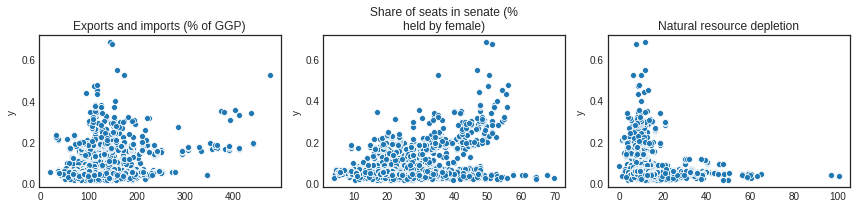

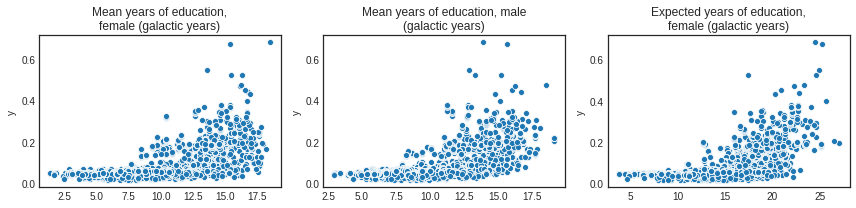

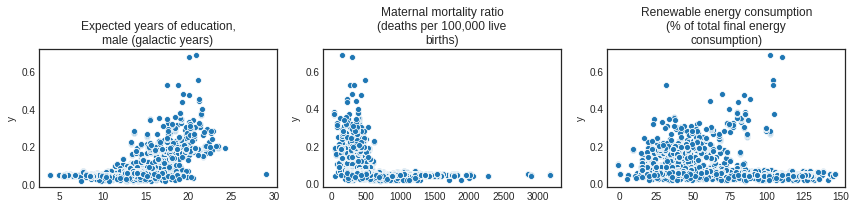

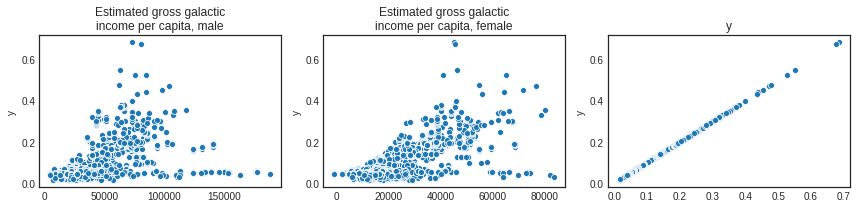

By year: 



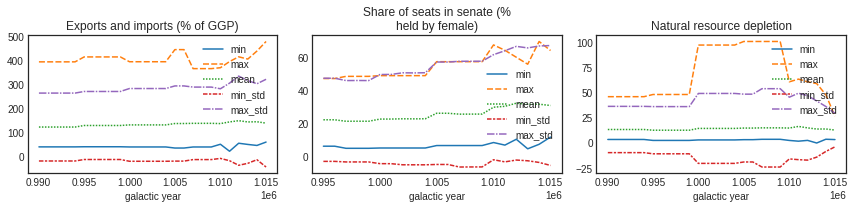

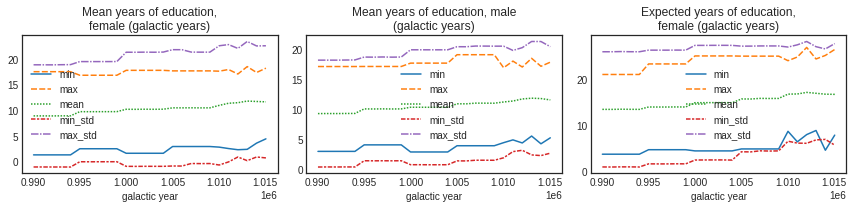

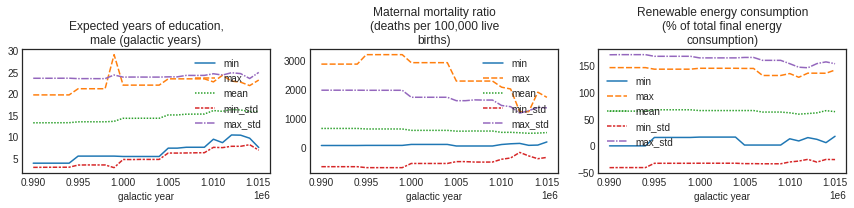

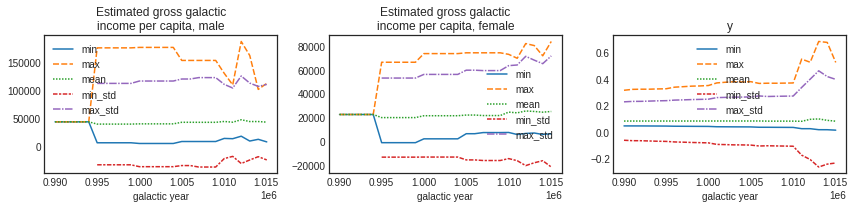

Box: 



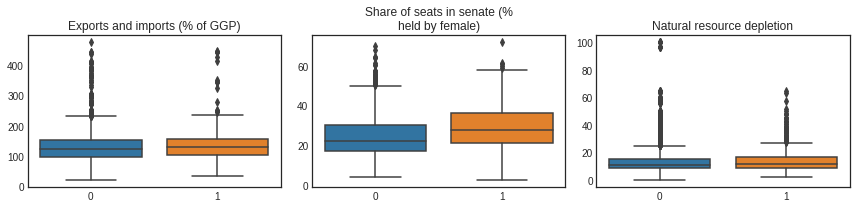

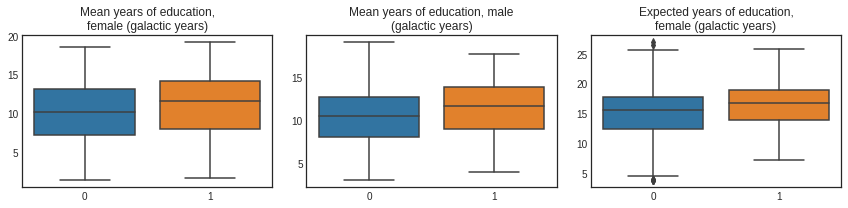

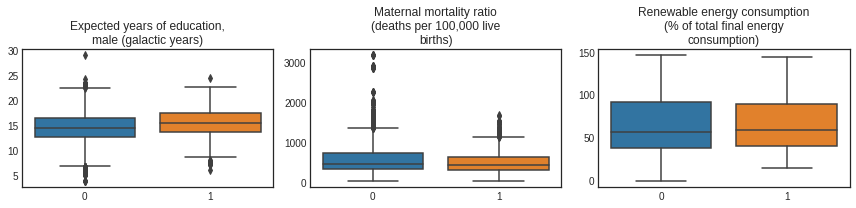

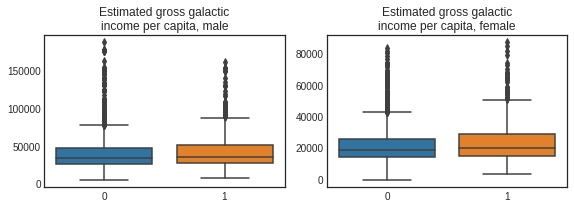

NaNs: 



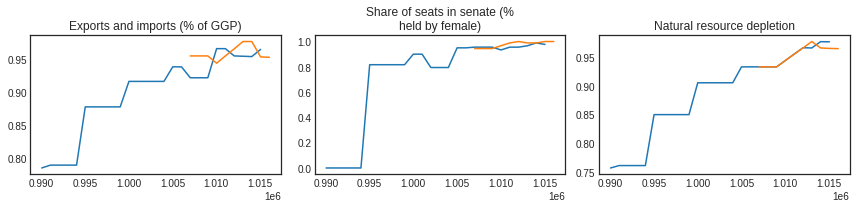

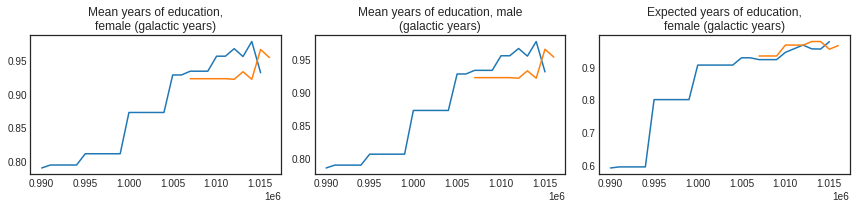

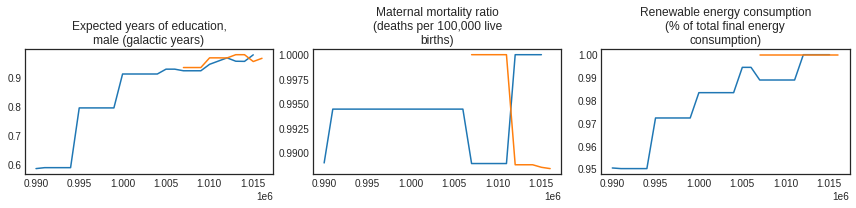

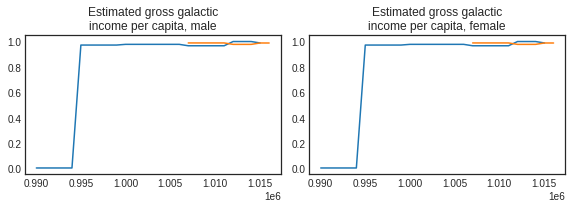

Data correlation: 



pearson  kendall  \
Exports and imports (% of GGP)                         0.20     0.11   
Share of seats in senate (% held by female)            0.42     0.15   
Natural resource depletion                            -0.22    -0.22   
Mean years of education, female (galactic years)       0.58     0.49   
Mean years of education, male (galactic years)         0.58     0.48   
Expected years of education, female (galactic y...     0.58     0.46   
Expected years of education, male (galactic years)     0.59     0.46   
Maternal mortality ratio (deaths per 100,000 li...    -0.39    -0.46   
Renewable energy consumption (% of total final ...    -0.28    -0.31   
Estimated gross galactic income per capita, male       0.48     0.42   
Estimated gross galactic income per capita, female     0.64     0.41   
y                                                      1.00     1.00   

                                                    spearman  skew  
Exports and imports (% of GGP)                          0.16  1.90  
Share of seats in senate (% held by female)             0.22  0.83  
Natural resource depletion                             -0.32  3.56  
Mean years of education, female (galactic years)        0.68  0.01  
Mean years of education, male (galactic years)          0.68  0.07  
Expected years of education, female (galactic y...      0.64 -0.37  
Expected years of education, male (galactic years)      0.63 -0.29  
Maternal mortality ratio (deaths per 100,000 li...     -0.65  2.01  
Renewable energy consumption (% of total final ...     -0.47  0.47  
Estimated gross galactic income per capita, male        0.59  2.20  
Estimated gross galactic income per capita, female      0.58  1.69  
y                                                       1.00  2.66

['Exports and imports (% of GGP)',
 'Share of seats in senate (% held by female)',
 'Natural resource depletion',
 'Mean years of education, female (galactic years)',
 'Mean years of education, male (galactic years)',
 'Expected years of education, female (galactic years)',
 'Expected years of education, male (galactic years)',
 'Maternal mortality ratio (deaths per 100,000 live births)',
 'Renewable energy consumption (% of total final energy consumption)',
 'Estimated gross galactic income per capita, male',
 'Estimated gross galactic income per capita, female']

In [44]:
data_desc(data_train, start_col=44)

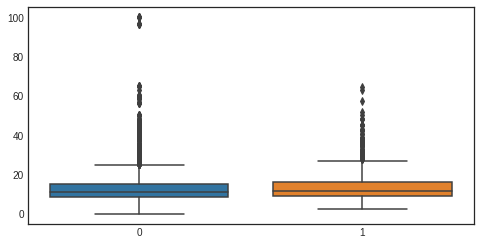

In [148]:
sns.boxplot(data=[data_train['Natural resource depletion'], data_test['Natural resource depletion']])

In [ ]:
features_drop += []

In [18]:
features_with_outliers += ['Natural resource depletion']
features_with_outliers

['Total unemployment rate (female to male ratio)',
 'Youth unemployment rate (female to male ratio)',
 'Gross galactic product (GGP), total',
 'Outer Galaxies direct investment, net inflows (% of GGP)',
 'Natural resource depletion']

#### Группа 6:

XY: 



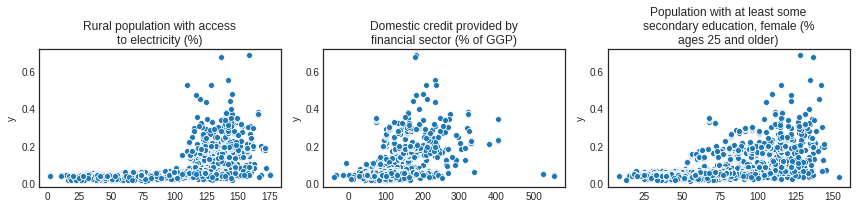

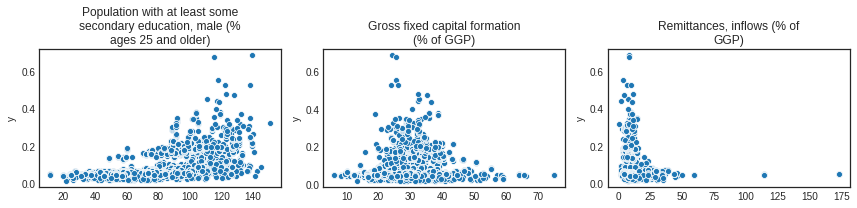

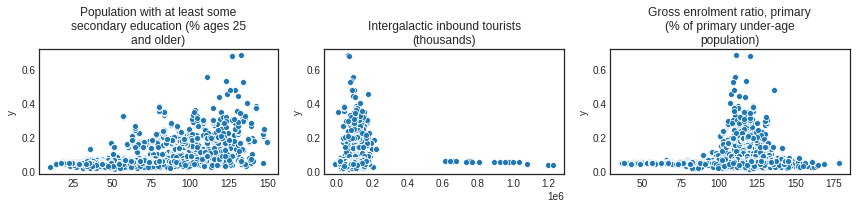

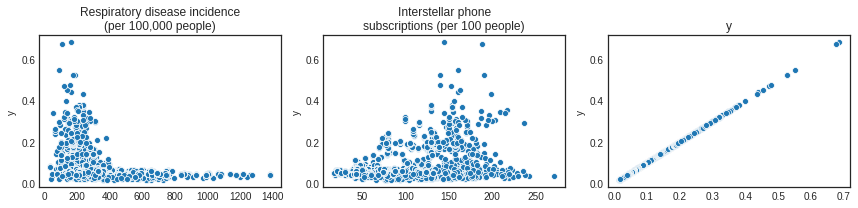

By year: 



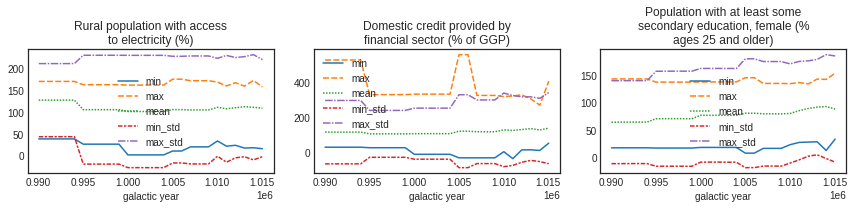

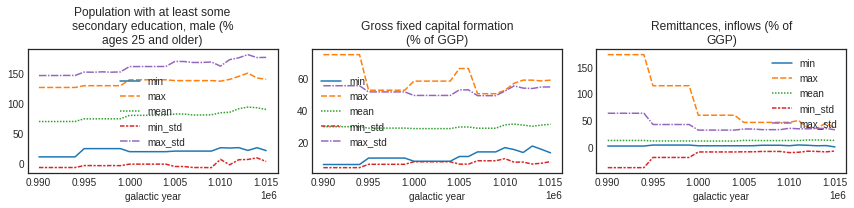

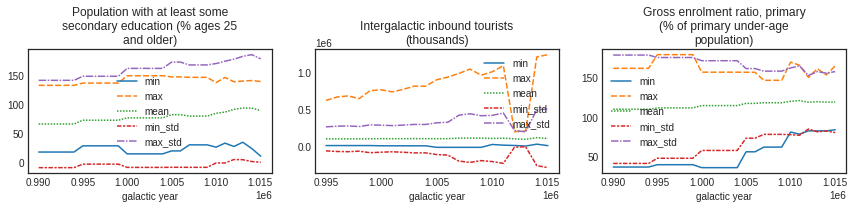

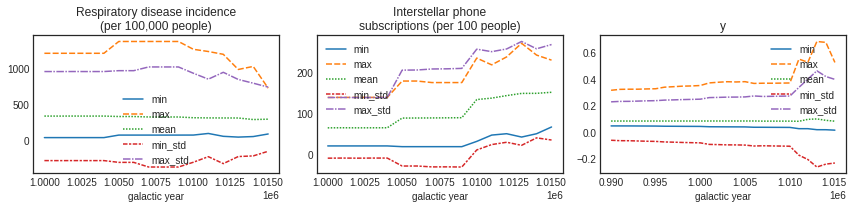

Box: 



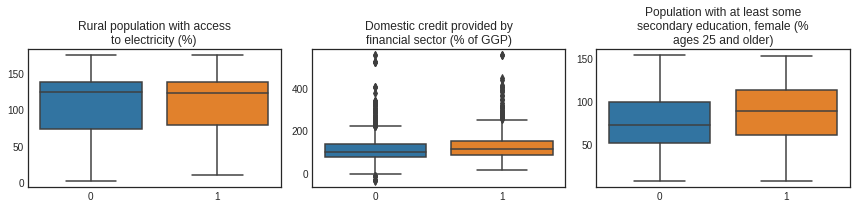

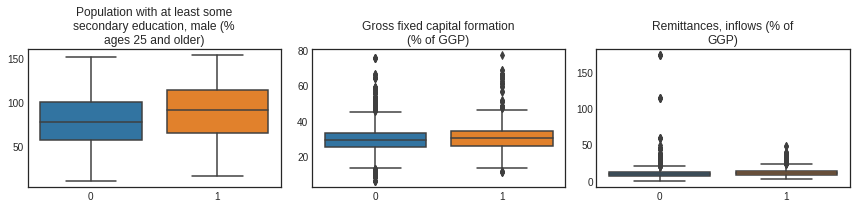

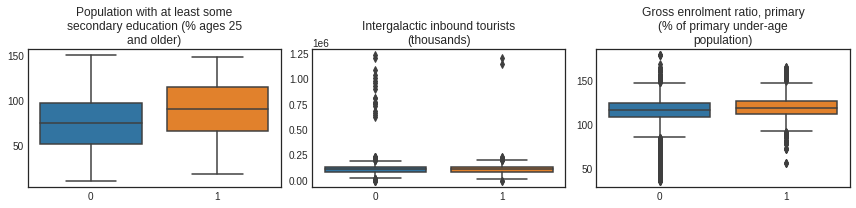

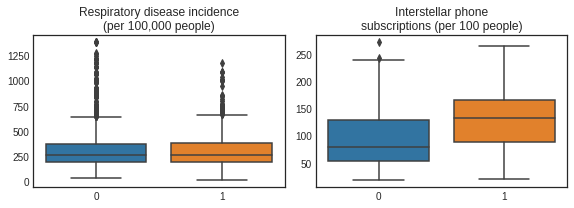

NaNs: 



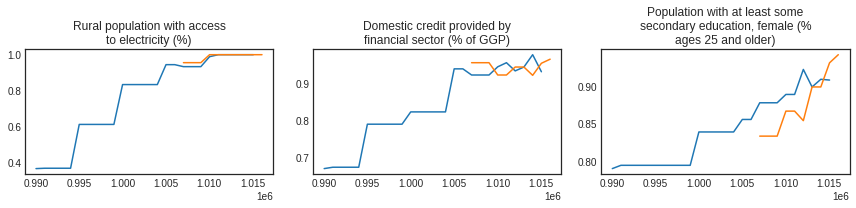

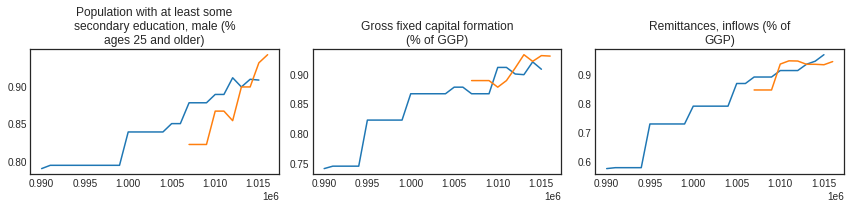

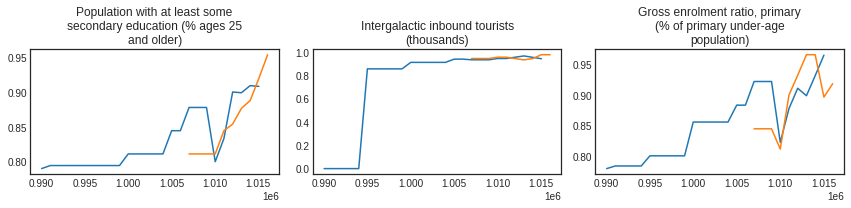

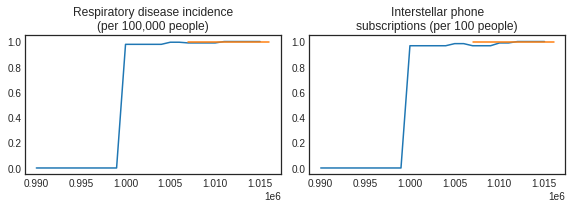

Data correlation: 



pearson  kendall  \
Rural population with access to electricity (%)        0.50     0.48   
Domestic credit provided by financial sector (%...     0.48     0.32   
Population with at least some secondary educati...     0.53     0.44   
Population with at least some secondary educati...     0.54     0.44   
Gross fixed capital formation (% of GGP)               0.09     0.13   
Remittances, inflows (% of GGP)                       -0.14    -0.12   
Population with at least some secondary educati...     0.51     0.42   
Intergalactic inbound tourists (thousands)             0.01     0.07   
Gross enrolment ratio, primary (% of primary un...     0.11     0.08   
Respiratory disease incidence (per 100,000 people)    -0.34    -0.34   
Interstellar phone subscriptions (per 100 people)      0.39     0.19   
y                                                      1.00     1.00   

                                                    spearman  skew  
Rural population with access to electricity (%)         0.67 -0.74  
Domestic credit provided by financial sector (%...      0.46  1.96  
Population with at least some secondary educati...      0.63  0.17  
Population with at least some secondary educati...      0.63  0.08  
Gross fixed capital formation (% of GGP)                0.18  0.92  
Remittances, inflows (% of GGP)                        -0.18  9.15  
Population with at least some secondary educati...      0.61  0.21  
Intergalactic inbound tourists (thousands)              0.10  8.97  
Gross enrolment ratio, primary (% of primary un...      0.12 -1.31  
Respiratory disease incidence (per 100,000 people)     -0.50  1.98  
Interstellar phone subscriptions (per 100 people)       0.27  0.68  
y                                                       1.00  2.66

['Rural population with access to electricity (%)',
 'Domestic credit provided by financial sector (% of GGP)',
 'Population with at least some secondary education, female (% ages 25 and older)',
 'Population with at least some secondary education, male (% ages 25 and older)',
 'Gross fixed capital formation (% of GGP)',
 'Remittances, inflows (% of GGP)',
 'Population with at least some secondary education (% ages 25 and older)',
 'Intergalactic inbound tourists (thousands)',
 'Gross enrolment ratio, primary (% of primary under-age population)',
 'Respiratory disease incidence (per 100,000 people)',
 'Interstellar phone subscriptions (per 100 people)']

In [51]:
data_desc(data_train, start_col=55)

In [34]:
features_drop += []
features_drop

['Population, total (millions)',
 'Population, ages 15–64 (millions)',
 'Population, ages 65 and older (millions)',
 'Population, under age 5 (millions)',
 'Gross galactic product (GGP), total']

In [19]:
features_with_outliers += [
 'Remittances, inflows (% of GGP)',
 'Intergalactic inbound tourists (thousands)',
]
features_with_outliers

['Total unemployment rate (female to male ratio)',
 'Youth unemployment rate (female to male ratio)',
 'Gross galactic product (GGP), total',
 'Outer Galaxies direct investment, net inflows (% of GGP)',
 'Natural resource depletion',
 'Remittances, inflows (% of GGP)',
 'Intergalactic inbound tourists (thousands)']

#### Группа 7:

XY: 



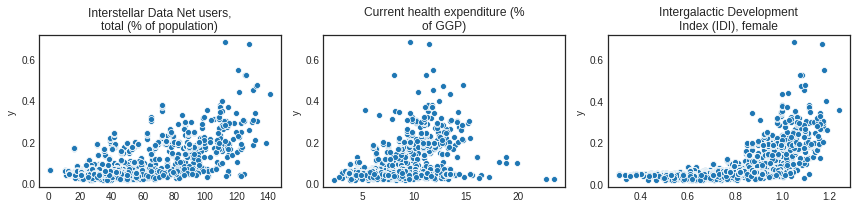

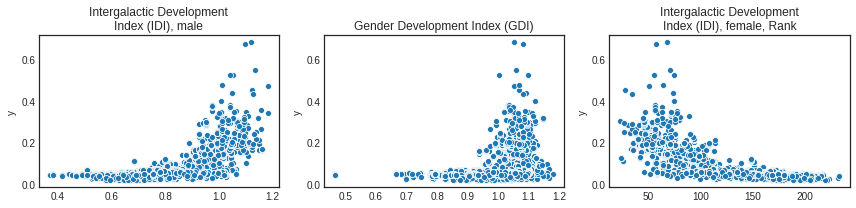

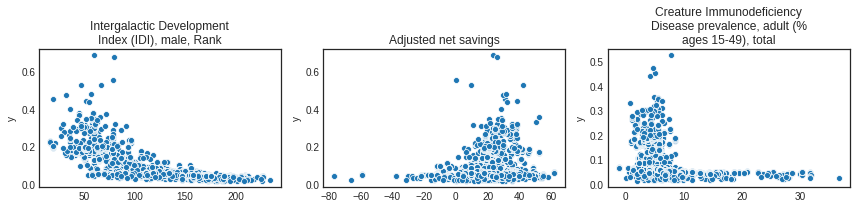

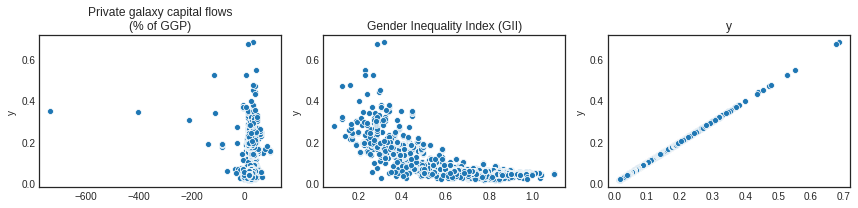

By year: 



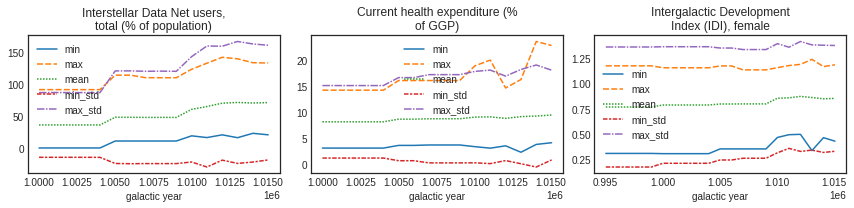

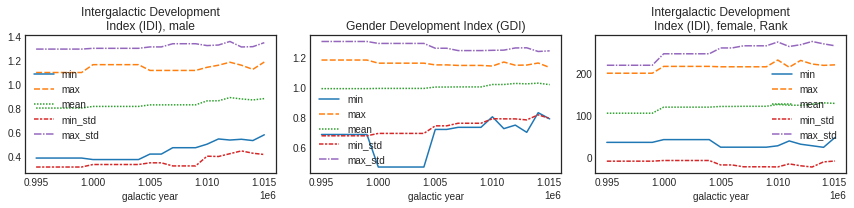

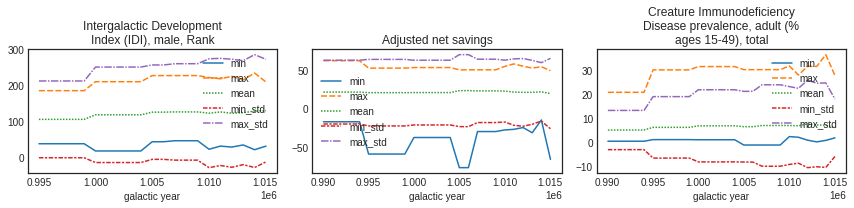

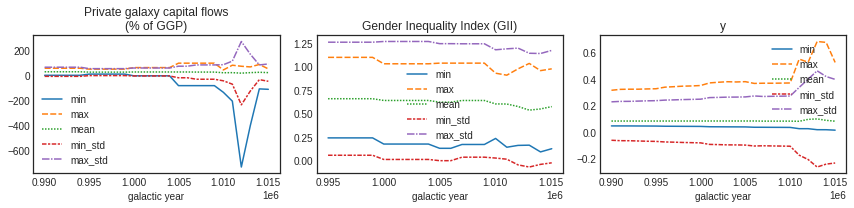

Box: 



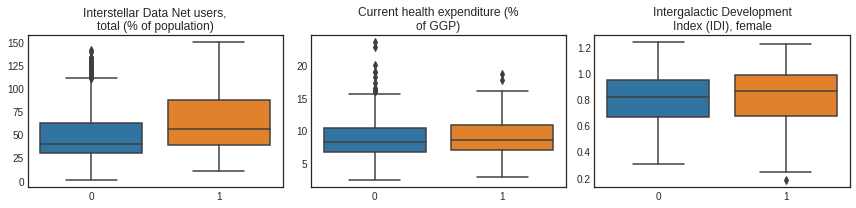

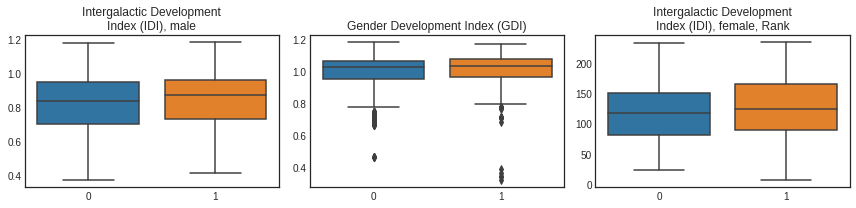

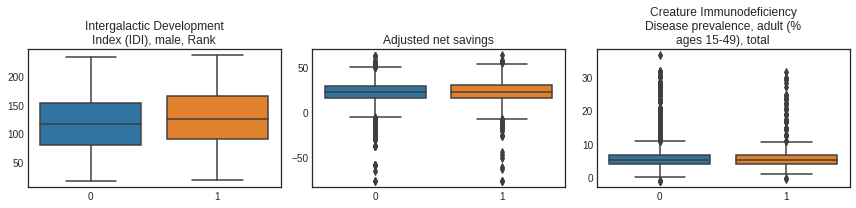

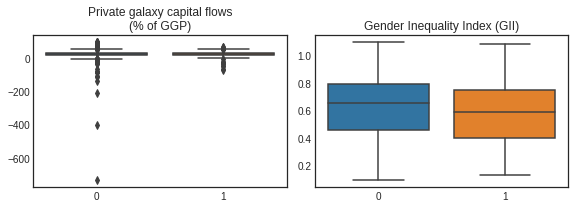

NaNs: 



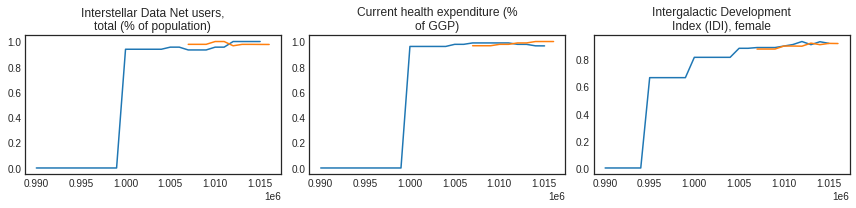

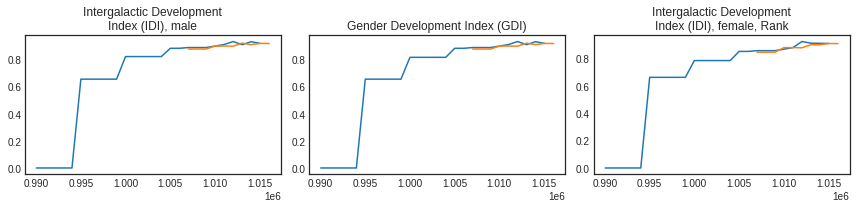

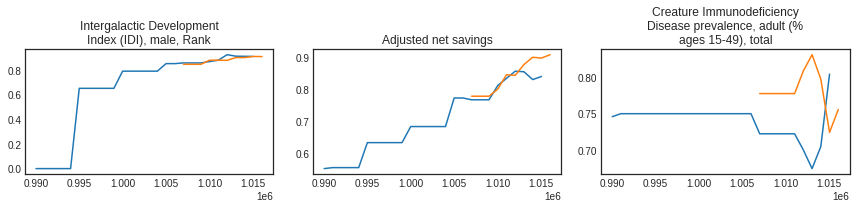

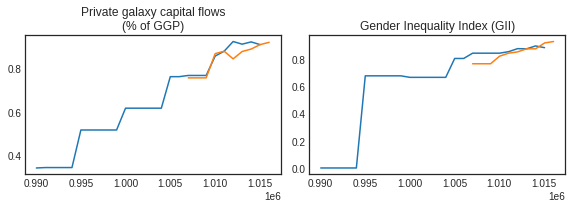

Data correlation: 



pearson  kendall  \
Interstellar Data Net users, total (% of popula...     0.64     0.30   
Current health expenditure (% of GGP)                  0.37     0.22   
Intergalactic Development Index (IDI), female          0.64     0.57   
Intergalactic Development Index (IDI), male            0.64     0.57   
Gender Development Index (GDI)                         0.37     0.35   
Intergalactic Development Index (IDI), female, ...    -0.67    -0.62   
Intergalactic Development Index (IDI), male, Rank     -0.69    -0.64   
Adjusted net savings                                   0.16     0.14   
Creature Immunodeficiency Disease prevalence, a...    -0.25    -0.30   
Private galaxy capital flows (% of GGP)               -0.08     0.02   
Gender Inequality Index (GII)                         -0.75    -0.58   
y                                                      1.00     1.00   

                                                    spearman   skew  
Interstellar Data Net users, total (% of popula...      0.44   1.11  
Current health expenditure (% of GGP)                   0.31   0.60  
Intergalactic Development Index (IDI), female           0.76  -0.30  
Intergalactic Development Index (IDI), male             0.76  -0.36  
Gender Development Index (GDI)                          0.52  -1.27  
Intergalactic Development Index (IDI), female, ...     -0.81   0.13  
Intergalactic Development Index (IDI), male, Rank      -0.83   0.07  
Adjusted net savings                                    0.20  -1.16  
Creature Immunodeficiency Disease prevalence, a...     -0.45   3.12  
Private galaxy capital flows (% of GGP)                 0.03 -18.33  
Gender Inequality Index (GII)                          -0.78  -0.26  
y                                                       1.00   2.66

['Interstellar Data Net users, total (% of population)',
 'Current health expenditure (% of GGP)',
 'Intergalactic Development Index (IDI), female',
 'Intergalactic Development Index (IDI), male',
 'Gender Development Index (GDI)',
 'Intergalactic Development Index (IDI), female, Rank',
 'Intergalactic Development Index (IDI), male, Rank',
 'Adjusted net savings ',
 'Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total',
 'Private galaxy capital flows (% of GGP)',
 'Gender Inequality Index (GII)']

In [54]:
data_desc(data_train, start_col=66)

In [20]:
features_drop += ['Adjusted net savings ']
features_drop

['Population, total (millions)',
 'Population, ages 15–64 (millions)',
 'Population, ages 65 and older (millions)',
 'Population, under age 5 (millions)',
 'Gross galactic product (GGP), total',
 'Adjusted net savings ']

In [21]:
features_with_outliers += [
 'Private galaxy capital flows (% of GGP)', 'Gender Development Index (GDI)']
features_with_outliers

['Total unemployment rate (female to male ratio)',
 'Youth unemployment rate (female to male ratio)',
 'Gross galactic product (GGP), total',
 'Outer Galaxies direct investment, net inflows (% of GGP)',
 'Natural resource depletion',
 'Remittances, inflows (% of GGP)',
 'Intergalactic inbound tourists (thousands)',
 'Private galaxy capital flows (% of GGP)',
 'Gender Development Index (GDI)']

In [22]:
features_drop = list(set(features_drop))
features_with_outliers = list(set(features_with_outliers))
features_new = list(set(features_new))
features_drop, features_with_outliers, features_new

(['Population, total (millions)',
  'Population, ages 65 and older (millions)',
  'Population, ages 15–64 (millions)',
  'Gross galactic product (GGP), total',
  'Population, under age 5 (millions)',
  'Adjusted net savings '],
 ['Natural resource depletion',
  'Gender Development Index (GDI)',
  'Outer Galaxies direct investment, net inflows (% of GGP)',
  'Youth unemployment rate (female to male ratio)',
  'Private galaxy capital flows (% of GGP)',
  'Total unemployment rate (female to male ratio)',
  'Intergalactic inbound tourists (thousands)',
  'Gross galactic product (GGP), total',
  'Remittances, inflows (% of GGP)'],
 ['Population, under age 5',
  'Population, ages 65 and older',
  'Mortality rate, grown up (per 1,000 people)',
  'Population, ages 15–64',
  'Years of education ratio',
  'Under 5 per 15-64'])

### Группы

In [23]:
features_indexes = [x for x in data_all.columns if 'index' in (x.lower())]
features_female = [x for x in data_all.columns if 'female' in (x.lower()) and 'ratio' not in (x.lower())]
features_male = [x for x in data_all.columns if ' male' in (x.lower()) and 'ratio' not in (x.lower())]
features_rank = [x for x in data_all.columns if 'rank' in (x.lower())]
features_low_corr = list(data_train.iloc[:,2:].columns[abs(data_train.iloc[:,2:].corrwith(data_train['y'])) < 0.5])
features_indexes, features_female, features_male, features_rank, features_low_corr

(['existence expectancy index',
  'Income Index',
  'Intergalactic Development Index (IDI)',
  'Education Index',
  'Intergalactic Development Index (IDI), Rank',
  'Intergalactic Development Index (IDI), female',
  'Intergalactic Development Index (IDI), male',
  'Gender Development Index (GDI)',
  'Intergalactic Development Index (IDI), female, Rank',
  'Intergalactic Development Index (IDI), male, Rank',
  'Gender Inequality Index (GII)'],
 ['Life expectancy at birth, female (galactic years)',
  'Adolescent birth rate (births per 1,000 female creatures ages 15-19)',
  'Labour force participation rate (% ages 15 and older), female',
  'Share of employment in nonagriculture, female (% of total employment in nonagriculture)',
  'Mortality rate, female grown up (per 1,000 people)',
  'Share of seats in senate (% held by female)',
  'Mean years of education, female (galactic years)',
  'Expected years of education, female (galactic years)',
  'Estimated gross galactic income per capita, 

In [24]:
for x in ['Adolescent birth rate (births per 1,000 female creatures ages 15-19)',
          'Share of employment in nonagriculture, female (% of total employment in nonagriculture)',
          'Share of seats in senate (% held by female)']:
    features_female.remove(x)
features_female

['Life expectancy at birth, female (galactic years)',
 'Labour force participation rate (% ages 15 and older), female',
 'Mortality rate, female grown up (per 1,000 people)',
 'Mean years of education, female (galactic years)',
 'Expected years of education, female (galactic years)',
 'Estimated gross galactic income per capita, female',
 'Population with at least some secondary education, female (% ages 25 and older)',
 'Intergalactic Development Index (IDI), female',
 'Intergalactic Development Index (IDI), female, Rank']

In [25]:
data_all['Life expectancy at birth ratio'] = data_all['Life expectancy at birth, female (galactic years)'] / \
                                             data_all['Life expectancy at birth, male (galactic years)']
data_all['Labour force participation rate (% ages 15 and older) ratio'] = data_all['Labour force participation rate (% ages 15 and older), female'] / \
                                             data_all['Labour force participation rate (% ages 15 and older), male']
data_all['Mortality rate ratio'] = data_all['Mortality rate, female grown up (per 1,000 people)'] / \
                                             data_all['Mortality rate, male grown up (per 1,000 people)']   
data_all['Mean years of education ratio'] = data_all['Mean years of education, female (galactic years)'] / \
                                            data_all['Mean years of education, male (galactic years)']
data_all['Expected years of education ratio'] = data_all['Expected years of education, female (galactic years)'] / \
                                                data_all['Expected years of education, male (galactic years)']
data_all['Estimated gross galactic income per capita ratio'] = data_all['Estimated gross galactic income per capita, female'] /  \
                                                                data_all['Estimated gross galactic income per capita, male']
data_all['Population with at least some secondary education ratio'] = data_all['Population with at least some secondary education, female (% ages 25 and older)'] / \
                                                                        data_all['Population with at least some secondary education, male (% ages 25 and older)']
data_all['Intergalactic Development Index (IDI) ratio'] = data_all['Intergalactic Development Index (IDI), female'] /  \
                                                            data_all['Intergalactic Development Index (IDI), male']
data_all['Intergalactic Development Index (IDI), Rank ratio'] = data_all['Intergalactic Development Index (IDI), female, Rank'] / \
                                                                data_all['Intergalactic Development Index (IDI), male, Rank']

features_new += ['Life expectancy at birth ratio', 'Labour force participation rate (% ages 15 and older) ratio', 
                 'Mortality rate ratio', 'Mean years of education ratio', 'Expected years of education ratio',
                 'Estimated gross galactic income per capita ratio', 'Population with at least some secondary education ratio',
                 'Population with at least some secondary education ratio', 'Intergalactic Development Index (IDI) ratio',
                 'Intergalactic Development Index (IDI), Rank ratio'
                ]

### check disribution (not done)

### percent cols (not done)

cols_percent = [x for x in data_train.columns if ('%' in x)]
cols_percent = [x for x in cols_percent if (any(data_train[x] > 100))]
(data_train[cols_percent] > 100).sum()

Будем считать, что у инопланетян другие проценты с максимумом > 100%

# Models

## Boosting

In [212]:
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process, neural_network
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn import metrics

#alg = ensemble.GradientBoostingRegressor(criterion='mse', random_state=111)
xgb_model = XGBRegressor(n_estimators=200, max_depth=5, random_state=45)
#xgb_model = neural_network.MLPRegressor(hidden_layer_sizes=(128,128,128), random_state=121, max_iter=400)
#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = ShuffleSplit(n_splits = 20, test_size = .2, train_size = .8, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

train_X = data_train.iloc[:,:-1]
train_y = data_train.iloc[:,[-1]]

train_X = fnl.fit_transform(train_X)
train_y = transform_y.fit_transform(train_y)

#score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
cv_results = cross_validate(xgb_model, train_X, train_y, \
                                            cv  = cv_split, return_train_score=True, scoring='neg_mean_squared_error')

print(cv_results['fit_time'].mean())
print(cv_results['train_score'].mean())
print(cv_results['test_score'].mean())
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
print(cv_results['test_score'].std()*3)   #let's know the worst that can happen!
    

xgb_model.fit(train_X, train_y)

#lr_model.fit(train_X, train_y, epochs=epochs, verbose=0, batch_size=batch_size)

pred_X = data_test.sort_index().reset_index(drop=True).copy()

pred_X = fnl.transform(pred_X)
pred_y = xgb_model.predict(pred_X)
pred_y = transform_y.inverse_transform(pred_y)



2.7687641382217407
-7.409086379084328e-07
-0.0002998764561198186
0.00029065228041146105


In [215]:
pred_y.max(), pred_y.min(), pred_y.mean()

(0.51981395, 0.014320672, 0.083932884)

In [ ]:
kf = KFold(n_splits=10, random_state=311, shuffle=True)

train_X = data_train.iloc[:,:-1]
train_y = data_train.iloc[:,[-1]]

train_X = fnl.fit_transform(train_X)
train_y = transform_y.fit_transform(train_y)

#score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
cv_results = cross_validate(xgb_model, train_X, train_y, \
                                            cv  = kf, return_train_score=True, scoring='neg_mean_squared_error')

print(cv_results['fit_time'].mean())
print(cv_results['train_score'].mean())
print(cv_results['test_score'].mean())
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
print(cv_results['test_score'].std()*3)   #let's know the worst that can happen!
    

xgb_model.fit(train_X, train_y)

#lr_model.fit(train_X, train_y, epochs=epochs, verbose=0, batch_size=batch_size)

pred_X = data_test.sort_index().reset_index(drop=True).copy()

pred_X = fnl.transform(pred_X)
pred_y = xgb_model.predict(pred_X)
pred_y = transform_y.inverse_transform(pred_y)


## Neural Network

### train_df, test_df

In [26]:
data_all = data_all.drop('y', axis=1).join(data_all['y'])

data_train = data_all.loc['train']
data_test = data_all.loc['test'].drop('y', axis=1)
print(data_train.shape, data_test.shape)

(3865, 95) (890, 94)


In [29]:
data_wrk = data_train.copy() #.loc[data_train['galactic year'] >= 1000000]

train_df, test_df = train_test_split(data_wrk, test_size=0.2, random_state=13)

# outliers
#train_df_outliers = train_df.loc[((train_df['y'].mean() - 3 * train_df['y'].std()) >= train_df['y']) ^ \
#                        (train_df['y'] >= (train_df['y'].mean() + 3 * train_df['y'].std()))]

#for i in range(20):
#    train_df = train_df.append(train_df_outliers)

print(train_df.shape, test_df.shape);


train_X = train_df.iloc[:,:-1]
train_y = train_df.iloc[:,[-1]]

test_X = test_df.iloc[:,:-1]
test_y = test_df.iloc[:,[-1]]

# preprocess
def preprop_wrk(data, features=[], drop=[]):
    drop += ['galaxy', 'galactic year']
    data.drop(drop, axis=1, inplace=True)
#    data[data < 0] = np.nan
    if not features:
        features = data.columns
    return data[features]

features = []
drop = []
drop = list(set(features_with_outliers + features_drop + features_new))
preprop = FunctionTransformer(preprop_wrk, kw_args={'features': features, 'drop': drop})

# imputer
imp = SimpleImputer(strategy='mean', 
                    #fill_value=0
                   )
#imp = KNNImputer()

#scaler
scale_X = MaxAbsScaler()
#scale_X = MinMaxScaler()
#scale_X = StandardScaler()


# missing indicator
ind = MissingIndicator(features='all')

fnl = make_pipeline(preprop, 
                    make_union(ind, 
                               make_pipeline(imp, 
                                             #norm,
                                             scale_X, 
                                             ),
                              ),                    
                   )

train_X = fnl.fit_transform(train_X)
test_X = fnl.transform(test_X)

transform_y = make_pipeline(
                FunctionTransformer(func=(lambda y: y), inverse_func=(lambda y: y)),
                #FunctionTransformer(func=(lambda y: y ** (-.57)), inverse_func=(lambda y: y ** (-1/.57))),
                #MinMaxScaler(),
                )

train_y = transform_y.fit_transform(train_y)
test_y = transform_y.transform(test_y)


from sklearn.utils import shuffle
train_X, train_y = shuffle(train_X, train_y, random_state=87)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape);
print(train_y.agg(['max', 'min']))

(3092, 95) (773, 95)
(3092, 126) (3092, 1) (773, 126) (773, 1)
       y
max 0.68
min 0.01


#### Хорошие модели

### Create model

In [30]:
def create_model(input_dim, learn_rate=0.001, dropout=.0, dims=[128], l2=1e-9):

    lr_model = keras.models.Sequential()
    lr_model.add(keras.Input(shape=(input_dim,) ))
    lr_model.add(keras.layers.Dense(dims[0], activation='relu', ))
    lr_model.add(keras.layers.Dropout(dropout))
    for dim in dims[1:]:

        lr_model.add(keras.layers.Dense(dim, activation='relu', kernel_initializer='random_uniform', 
#                                   kernel_regularizer=keras.regularizers.l2(l2),
                                   ))
#        lr_model.add(keras.layers.Dropout(dropout))
    #                use_bias=True,
    #                kernel_regularizer=keras.regularizers.l2(1e-6),
    #                bias_regularizer=keras.regularizers.l2(1e-10),
    #                activity_regularizer=keras.regularizers.l2(1e-10)               



    lr_model.add(keras.layers.Dense(1, activation='relu', kernel_initializer='random_uniform'
                                   ))

    # compile the model
    lr_model.compile(loss='mean_squared_error', 
                  optimizer=keras.optimizers.Adam(learning_rate=learn_rate), # keras.optimizers.RMSprop(lr=learn_rate),
                  metrics=[keras.metrics.RootMeanSquaredError()])
    return lr_model

def plot_history(history):
    epochs = history.epoch

    hist = pd.DataFrame(history.history)
    if "val_root_mean_squared_error" in hist.columns:
        rmse = hist[["root_mean_squared_error", "val_root_mean_squared_error"]]
    else:
        rmse = hist[["root_mean_squared_error",]]

    rcParams['figure.figsize'] = 8, 4

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Root Mean Squared Error")

    plt.plot(epochs, rmse, label=list(rmse.columns))
    plt.legend(list(rmse.columns))
    plt.ylim([min(rmse.min())*0.94, max(rmse.max())* 1.05])
    plt.show()

def compute_sample_weights(y, bins=10):
    hist, bin_edges = np.histogram(y, bins = bins)
    classes = y.apply(lambda x: pd.cut(x, bin_edges, labels = False, 
                                                  include_lowest = True)).values
    sample_weights = compute_sample_weight('balanced', classes)
    return sample_weights

### Train, plot, eval

In [31]:
np.random.seed(13)

Epoch 1/550
20/20 [==============================] - 1s 28ms/step - loss: 0.1353 - root_mean_squared_error: 0.0972 - val_loss: 0.2209 - val_root_mean_squared_error: 0.0964 - lr: 1.0000e-04
Epoch 2/550
20/20 [==============================] - 0s 15ms/step - loss: 0.1245 - root_mean_squared_error: 0.0836 - val_loss: 0.2010 - val_root_mean_squared_error: 0.0799 - lr: 1.0000e-04
Epoch 3/550
20/20 [==============================] - 0s 16ms/step - loss: 0.1052 - root_mean_squared_error: 0.0677 - val_loss: 0.1655 - val_root_mean_squared_error: 0.0696 - lr: 1.0000e-04
Epoch 4/550
20/20 [==============================] - 0s 16ms/step - loss: 0.0788 - root_mean_squared_error: 0.0937 - val_loss: 0.1089 - val_root_mean_squared_error: 0.1243 - lr: 1.0000e-04
Epoch 5/550
20/20 [==============================] - 0s 14ms/step - loss: 0.0439 - root_mean_squared_error: 0.1541 - val_loss: 0.0682 - val_root_mean_squared_error: 0.1910 - lr: 1.0000e-04
Epoch 6/550
20/20 [==============================] - 1s

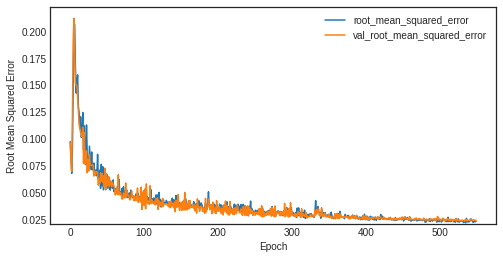

In [67]:
def init_model(first_layer):
    
    learn_rate = 0.0001

    lr_model = create_model(first_layer, learn_rate=learn_rate, dropout=.2, dims=[first_layer] * 4, l2=1e-3)
    #lr_model = create_model(first_layer, learn_rate=learn_rate, dropout=.2, dims=[160, 160, 160], l2=1e-3)
    return lr_model

batch_size = 128 #int(train_X.shape[0]/1) 
epochs = 550 # 100
sample_bins = 10

def scheduler(epoch, learn_rate):
    if epoch < 200:
        return learn_rate
    else:
        return learn_rate * np.exp(.00002 * (200 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
callbacks = [lr_scheduler, 
            # early_stopping
            ]

first_layer = train_X.shape[1]

lr_model = init_model(first_layer)

history = lr_model.fit(train_X, train_y, validation_split=.2, sample_weight=compute_sample_weights(train_y, sample_bins),
                       callbacks=callbacks, epochs=epochs, verbose=1, batch_size=batch_size)
print()
scores = lr_model.evaluate(x=test_X, y=test_y, batch_size=test_X.shape[0])

# plot
plot_history(history)

In [68]:
val = pd.DataFrame(transform_y.inverse_transform(lr_model.predict(test_X))).join(test_y.reset_index())
val['dif'] = abs(val[0] - val['y'])
display(val.agg(['max', 'mean', 'min', 'std', 'median']))
display(val.sort_values('dif', ascending=False))

0    index    y  dif
max    0.50 3,860.00 0.38 0.13
mean   0.09 1,911.48 0.08 0.01
min    0.04     9.00 0.02 0.00
std    0.07 1,105.95 0.06 0.02
median 0.06 1,885.00 0.06 0.01

0  index    y  dif
572 0.50   3370 0.37 0.13
443 0.17   3575 0.04 0.13
199 0.43   3729 0.30 0.13
299 0.24   3785 0.35 0.11
3   0.15   1639 0.06 0.10
563 0.28   3352 0.18 0.10
654 0.12   2345 0.22 0.10
128 0.12   2554 0.22 0.09
230 0.12   2223 0.21 0.09
88  0.15   3081 0.06 0.09
278 0.14   3295 0.05 0.09
411 0.40   2818 0.31 0.09
449 0.14    824 0.06 0.09
726 0.20   3798 0.14 0.06
314 0.23   3594 0.30 0.06
160 0.12   3856 0.06 0.06
42  0.37   3463 0.31 0.06
333 0.18   3662 0.12 0.06
305 0.21   3333 0.15 0.06
49  0.35   2744 0.29 0.06
668 0.26   3483 0.21 0.05
167 0.23   3008 0.17 0.05
588 0.12   3636 0.07 0.05
331 0.25   3589 0.19 0.05
438 0.24   3725 0.19 0.05
575 0.18    971 0.13 0.05
413 0.10   2519 0.05 0.05
32  0.26   3630 0.31 0.05
216 0.10   3760 0.05 0.05
376 0.33   2579 0.38 0.05
617 0.14    462 0.09 0.05
176 0.10   3181 0.05 0.05
497 0.10   2649 0.05 0.05
481 0.08   3855 0.03 0.05
319 0.10   3834 0.06 0.04
544 0.32   3784 0.27 0.04
90  0.10   1454 0.06 0.04
625 0.17   2956 0.13 0.04
101 0.15   2912 0.19 0.04
499 0.10   1656 0.06 0.04
408 0.12    158 0.16 0.04
663 0.39   3539 0.35 0.04
265 0.09   2299 0.05 0.04
35  0.08   3149 0.12 0.04
760 0.08   3421 0.04 0.04
258 0.30   1134 0.34 0.04
441 0.17   3673 0.13 0.04
567 0.09   3661 0.05 0.04
752 0.21   3746 0.18 0.04
63  0.33   2943 0.29 0.04
385 0.16   1296 0.20 0.04
675 0.23   3507 0.19 0.04
412 0.25   2967 0.22 0.04
213 0.12   2877 0.16 0.04
605 0.20   1374 0.17 0.04
524 0.14   2884 0.11 0.04
478 0.25   3246 0.22 0.04
548 0.25   3066 0.22 0.04
259 0.08   2119 0.05 0.03
58  0.07   3730 0.04 0.03
678 0.08   2334 0.05 0.03
85  0.26   2602 0.30 0.03
426 0.09   3830 0.06 0.03
242 0.12   3021 0.15 0.03
113 0.31   3566 0.28 0.03
761 0.09    683 0.06 0.03
537 0.09   1546 0.05 0.03
688 0.16   1003 0.13 0.03
397 0.22   1880 0.19 0.03
623 0.16     94 0.20 0.03
409 0.16   3288 0.13 0.03
463 0.19   1761 0.16 0.03
749 0.10   2799 0.07 0.03
102 0.12   3307 0.15 0.03
97  0.08   1423 0.05 0.03
711 0.10    193 0.13 0.03
68  0.08   3765 0.05 0.03
503 0.19   1772 0.22 0.03
622 0.27   3664 0.30 0.03
346 0.22   1870 0.19 0.03
291 0.16   3387 0.19 0.03
723 0.08   2112 0.11 0.03
312 0.13   2543 0.16 0.03
370 0.31   1404 0.34 0.03
146 0.30   1034 0.33 0.03
595 0.16    735 0.13 0.03
133 0.19   1452 0.16 0.03
76  0.08   3452 0.05 0.03
420 0.09   3380 0.06 0.03
202 0.11   3547 0.08 0.03
578 0.18   1307 0.16 0.03
709 0.12   1841 0.15 0.03
526 0.08   2205 0.11 0.03
450 0.29   2457 0.32 0.03
235 0.10     66 0.07 0.03
157 0.18   1124 0.16 0.03
676 0.19    141 0.17 0.03
1   0.10    442 0.07 0.03
476 0.07   3741 0.05 0.03
486 0.11     47 0.13 0.03
92  0.04   3772 0.02 0.03
122 0.07   3860 0.04 0.03
505 0.07   3704 0.05 0.03
531 0.04   3737 0.02 0.03
561 0.07   3849 0.05 0.03
360 0.22   2576 0.20 0.03
558 0.20   3686 0.18 0.02
210 0.05   3846 0.03 0.02
290 0.05   3836 0.02 0.02
465 0.10    353 0.07 0.02
87  0.10    672 0.07 0.02
685 0.09    328 0.07 0.02
43  0.23   2061 0.25 0.02
446 0.09   3369 0.07 0.02
425 0.15   2165 0.17 0.02
768 0.09   3542 0.07 0.02
239 0.12   2326 0.14 0.02
427 0.08   2556 0.05 0.02
64  0.08   1911 0.05 0.02
368 0.11   1923 0.13 0.02
336 0.07   3306 0.05 0.02
86  0.31   3609 0.29 0.02
71  0.05   3723 0.02 0.02
184 0.07   3505 0.04 0.02
72  0.04   3645 0.02 0.02
650 0.09   1594 0.07 0.02
320 0.19   3613 0.17 0.02
273 0.12   2598 0.14 0.02
389 0.09   2290 0.07 0.02
73  0.16   3493 0.14 0.02
720 0.08    570 0.06 0.02
418 0.04   3840 0.02 0.02
204 0.09   1098 0.07 0.02
100 0.07   2950 0.05 0.02
315 0.20   1210 0.18 0.02
249 0.08   1026 0.06 0.02
556 0.04   3642 0.02 0.02
191 0.06   3651 0.04 0.02
740 0.16   3518 0.14 0.02
318 0.07   1434 0.05 0.02
84  0.05   2796 0.07 0.02
510 0.08   3748 0.06 0.02
153 0.08   2144 0.10 0.02
119 0.07    444 0.05 0.02
7   0.09   2908 0.11 0.02
19  0.05   3641 0.03 0.02
542 0.08   1600 0.06 0.02
559 0.05   1863 0.07 0.02
734 0.21   3461 0.19 0.02
297 0.04   3667 0.03 0.02
107 0.21   1709 0.19 0.02
237 0.09    864 0.11 0.02
244 0.09    222 0.07 0.02
405

In [165]:
pd.concat([data_test.describe(include='all'), data_test.iloc[[663]]]).transpose()

count unique  \
galactic year                                      890.00    NaN   
galaxy                                                890    172   
existence expectancy index                         890.00    NaN   
existence expectancy at birth                      890.00    NaN   
Gross income per capita                            890.00    NaN   
Income Index                                       890.00    NaN   
Expected years of education (galactic years)       890.00    NaN   
Mean years of education (galactic years)           887.00    NaN   
Intergalactic Development Index (IDI)              887.00    NaN   
Education Index                                    887.00    NaN   
Intergalactic Development Index (IDI), Rank        885.00    NaN   
Population using at least basic drinking-water ... 885.00    NaN   
Population using at least basic sanitation serv... 885.00    NaN   
Gross capital formation (% of GGP)                 841.00    NaN   
Population, total (millions)                       890.00    NaN   
Population, urban (%)                              890.00    NaN   
Mortality rate, under-five (per 1,000 live births) 890.00    NaN   
Mortality rate, infant (per 1,000 live births)     890.00    NaN   
Old age dependency ratio (old age (65 and older... 885.00    NaN   
Population, ages 15–64 (millions)                  885.00    NaN   
Population, ages 65 and older (millions)           885.00    NaN   
Life expectancy at birth, male (galactic years)    885.00    NaN   
Life expectancy at birth, female (galactic years)  885.00    NaN   
Population, under age 5 (millions)                 885.00    NaN   
Young age (0-14) dependency ratio (per 100 crea... 885.00    NaN   
Adolescent birth rate (births per 1,000 female ... 885.00    NaN   
Total unemployment rate (female to male ratio)     877.00    NaN   
Vulnerable employment (% of total employment)      877.00    NaN   
Unemployment, total (% of labour force)            877.00    NaN   
Employment in agriculture (% of total employment)  877.00    NaN   
Labour force participation rate (% ages 15 and ... 877.00    NaN   
Labour force participation rate (% ages 15 and ... 877.00    NaN   
Employment in services (% of total employment)     877.00    NaN   
Labour force participation rate (% ages 15 and ... 877.00    NaN   
Employment to population ratio (% ages 15 and o... 877.00    NaN   
Jungle area (% of total land area)                 880.00    NaN   
Share of employment in nonagriculture, female (... 877.00    NaN   
Youth unemployment rate (female to male ratio)     877.00    NaN   
Unemployment, youth (% ages 15–24)                 877.00    NaN   
Mortality rate, female grown up (per 1,000 people) 884.00    NaN   
Mortality rate, male grown up (per 1,000 people)   884.00    NaN   
Infants lacking immunization, red hot disease (... 887.00    NaN   
Infants lacking immunization, Combination Vacci... 887.00    NaN   
Gross galactic product (GGP) per capita            877.00    NaN   
Gross galactic product (GGP), total                877.00    NaN   
Outer Galaxies direct investment, net inflows (... 885.00    NaN   
Exports and imports (% of GGP)                     854.00    NaN   
Share of seats in senate (% held by female)        869.00    NaN   
Natural resource depletion                         849.00    NaN   
Mean years of education, female (galactic years)   828.00    NaN   
Mean years of education, male (galactic years)     828.00    NaN   
Expected years of education, female (galactic y... 852.00    NaN   
Expected years of education, male (galactic years) 852.00    NaN   
Maternal mortality ratio (deaths per 100,000 li... 885.00    NaN   
Renewable energy consumption (% of total final ... 890.00    NaN   
Estimated gross galactic income per capita, male   877.00    NaN   
Estimated gross galactic income per capita, female 877.00    NaN   
Rural population with access to electricity (%)    878.00    NaN   
Domestic credit provided by financial se

In [303]:
(sum((val[0]-val['y']) ** 2) / val.shape[0]) ** .5

0.009512657374161175

## KFold and ShuffleSplit


1/1 [==============================] - 0s 2ms/step - loss: 3.6414e-04 - root_mean_squared_error: 0.0191


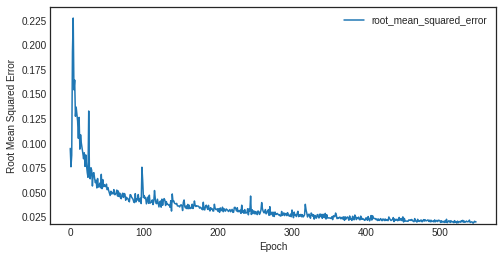


1/1 [==============================] - 0s 2ms/step - loss: 2.9856e-04 - root_mean_squared_error: 0.0173


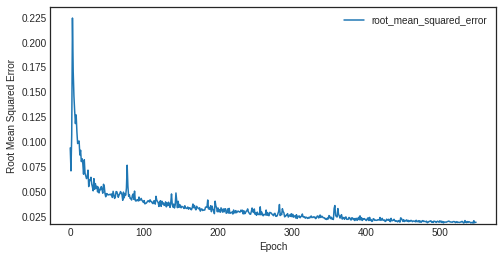


1/1 [==============================] - 0s 2ms/step - loss: 2.7033e-04 - root_mean_squared_error: 0.0164


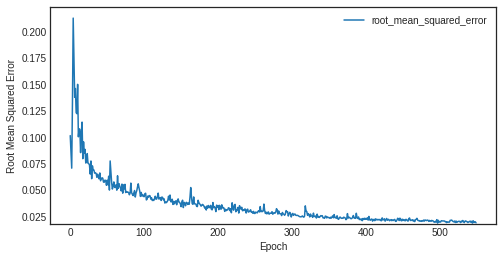


1/1 [==============================] - 0s 5ms/step - loss: 5.2335e-04 - root_mean_squared_error: 0.0229


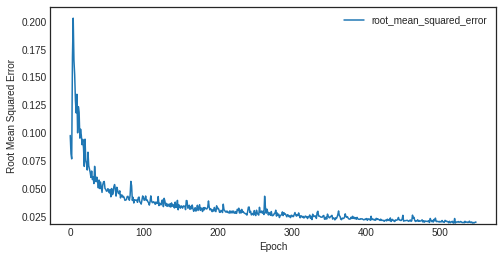


1/1 [==============================] - 0s 2ms/step - loss: 2.4613e-04 - root_mean_squared_error: 0.0157


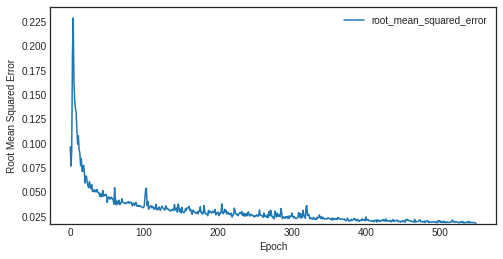


1/1 [==============================] - 0s 2ms/step - loss: 3.6715e-04 - root_mean_squared_error: 0.0192


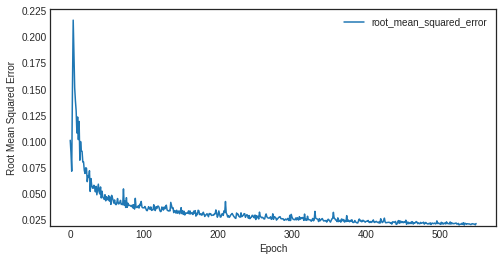


1/1 [==============================] - 0s 2ms/step - loss: 4.3626e-04 - root_mean_squared_error: 0.0209


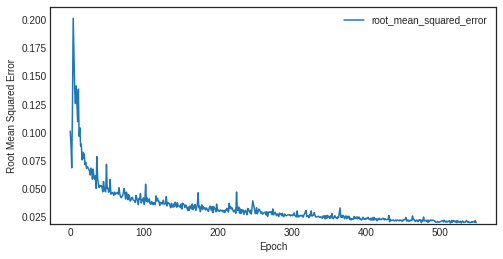


1/1 [==============================] - 0s 5ms/step - loss: 2.6269e-04 - root_mean_squared_error: 0.0162


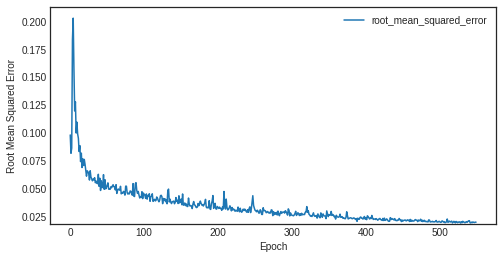


1/1 [==============================] - 0s 3ms/step - loss: 2.7489e-04 - root_mean_squared_error: 0.0166


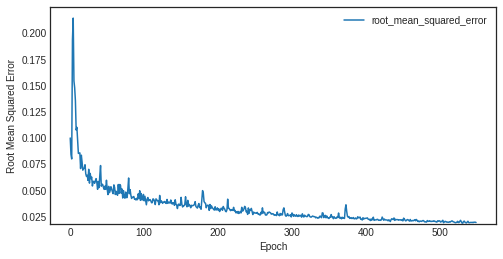


1/1 [==============================] - 0s 2ms/step - loss: 4.2209e-04 - root_mean_squared_error: 0.0205


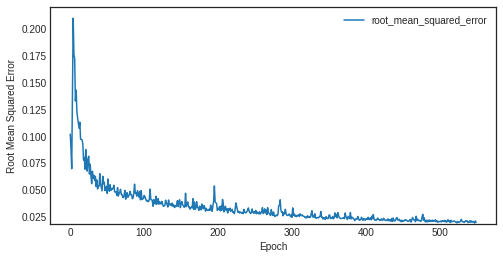

Mean error:  0.018474900163710117
Mean and max max diff: 0.11521385 0.1681734
Std * 3: 0.006866014086860393


In [69]:
kfold_history = []
kfold_scores = []
kfold_max_diff = []
kfold_models = []

kf = KFold(n_splits=10, random_state=311, shuffle=True)
for train_index, test_index in kf.split(data_wrk):
    # prepare data
    train_df, test_df = data_wrk.iloc[train_index], data_wrk.iloc[test_index]

    train_X = train_df.iloc[:,:-1]
    train_y = train_df.iloc[:,[-1]]

    test_X = test_df.iloc[:,:-1]
    test_y = test_df.iloc[:,[-1]]

    train_X = fnl.fit_transform(train_X)
    test_X = fnl.transform(test_X)

    train_y = transform_y.fit_transform(train_y)
    test_y = transform_y.transform(test_y)

    # create model
#    first_layer = train_X.shape[1]
#    lr_model = create_model(first_layer, learn_rate=0.0001, dropout=.05, dims=[80, 80], l2=1e-11)

#    batch_size=25 # 5
#    epochs=100 # 100
    lr_model = init_model(first_layer)

    kfold_history.append(lr_model.fit(train_X, train_y, validation_split=0., sample_weight=compute_sample_weights(train_y, sample_bins),
                                      callbacks=callbacks, epochs=epochs, verbose=0, batch_size=batch_size))
    print()
    kfold_scores.append(lr_model.evaluate(x=test_X, y=test_y, batch_size=test_X.shape[0]))
    kfold_max_diff.append(max(transform_y.inverse_transform(lr_model.predict(test_X)) - np.array(test_y)))
    kfold_models.append(lr_model)
    plot_history(kfold_history[-1])
#print(kfold_scores)
print('Mean error: ', np.mean([x[1] for x in kfold_scores]))
print('Mean and max max diff:', np.mean(kfold_max_diff), np.max(kfold_max_diff))
print('Std * 3:', np.std([x[1] for x in kfold_scores]) * 3)


1/1 [==============================] - 0s 2ms/step - loss: 4.9383e-04 - root_mean_squared_error: 0.0222


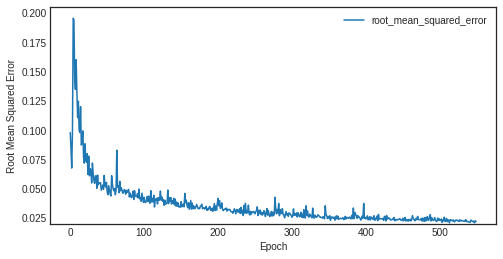


1/1 [==============================] - 0s 2ms/step - loss: 3.7829e-04 - root_mean_squared_error: 0.0194


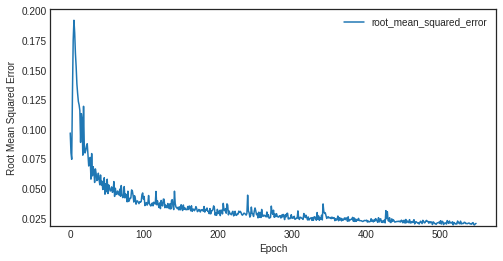


1/1 [==============================] - 0s 2ms/step - loss: 5.0576e-04 - root_mean_squared_error: 0.0225


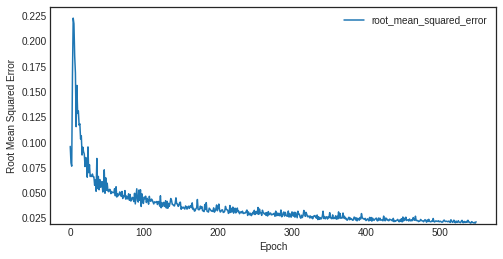


1/1 [==============================] - 0s 1ms/step - loss: 4.7766e-04 - root_mean_squared_error: 0.0219


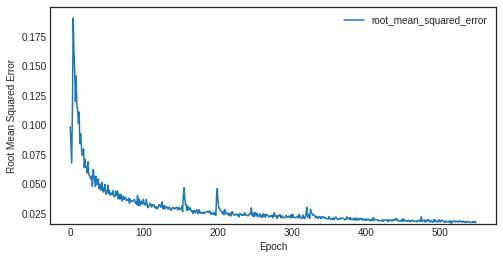


1/1 [==============================] - 0s 2ms/step - loss: 3.8474e-04 - root_mean_squared_error: 0.0196


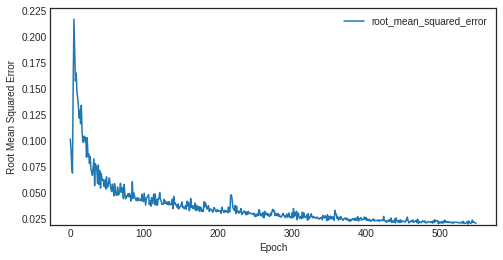


1/1 [==============================] - 0s 2ms/step - loss: 3.3592e-04 - root_mean_squared_error: 0.0183


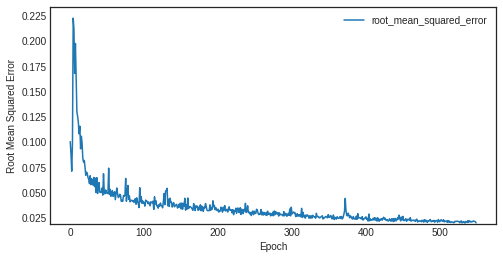


1/1 [==============================] - 0s 2ms/step - loss: 3.5495e-04 - root_mean_squared_error: 0.0188


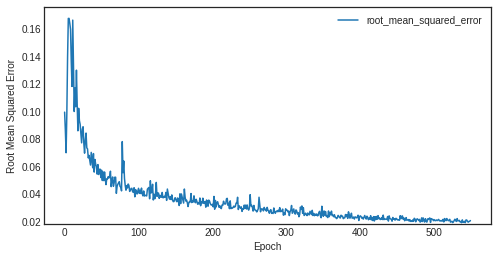


1/1 [==============================] - 0s 2ms/step - loss: 3.2656e-04 - root_mean_squared_error: 0.0181


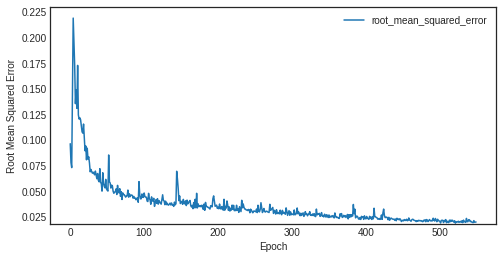


1/1 [==============================] - 0s 2ms/step - loss: 3.8674e-04 - root_mean_squared_error: 0.0197


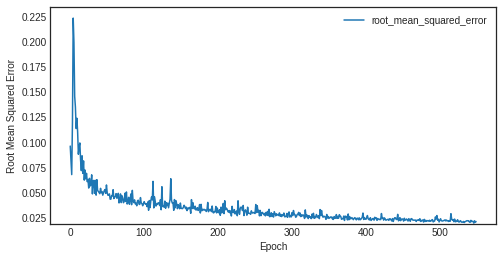


1/1 [==============================] - 0s 2ms/step - loss: 4.1756e-04 - root_mean_squared_error: 0.0204


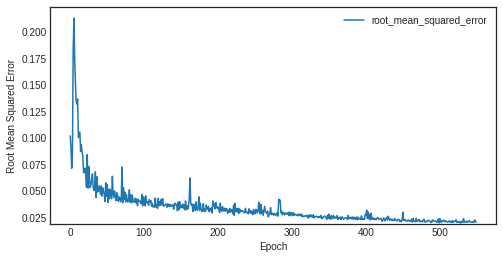

Mean error:  0.020097043365240097
Mean and max max diff: 0.14148314 0.20925707
Std * 3: 0.004559149921908677


In [70]:
shuffle_history = []
shuffle_scores = []
shuffle_max_diff = []
shuffle_models = []

cv_split = ShuffleSplit(n_splits = 10, test_size = .2, train_size = .7, random_state = 777 ) # run model 10x with 60/30 split intentionally leaving out 10%

for train_index, test_index in cv_split.split(data_wrk):
    # prepare data
    train_df, test_df = data_wrk.iloc[train_index], data_wrk.iloc[test_index]

    train_X = train_df.iloc[:,:-1]
    train_y = train_df.iloc[:,[-1]]

    test_X = test_df.iloc[:,:-1]
    test_y = test_df.iloc[:,[-1]]

    train_X = fnl.fit_transform(train_X)
    test_X = fnl.transform(test_X)

    train_y = transform_y.fit_transform(train_y)
    test_y = transform_y.transform(test_y)

    # create model
#    first_layer = train_X.shape[1]
#    lr_model = create_model(first_layer, learn_rate=0.0001, dropout=.05, dims=[80, 80], l2=1e-11)

#    batch_size=25 # 5
#    epochs=100 # 100
    lr_model = init_model(first_layer)

    shuffle_history.append(lr_model.fit(train_X, train_y, validation_split=0., sample_weight=compute_sample_weights(train_y, sample_bins),
                                        callbacks=callbacks, epochs=epochs, verbose=0, batch_size=batch_size))
    print()
    shuffle_scores.append(lr_model.evaluate(x=test_X, y=test_y, batch_size=test_X.shape[0]))
    shuffle_max_diff.append(max(transform_y.inverse_transform(lr_model.predict(test_X)) - np.array(test_y)))
    shuffle_models.append(lr_model)
    plot_history(shuffle_history[-1])
print('Mean error: ', np.mean([x[1] for x in shuffle_scores]))
print('Mean and max max diff:', np.mean(shuffle_max_diff), np.max(shuffle_max_diff))
print('Std * 3:', np.std([x[1] for x in shuffle_scores]) * 3)

## NN Feature selection

## Ensemble NN

In [ ]:
# cross validation estimation of performance
n_folds = 10
kfold = KFold(n_folds, True, 1)
scores, members = list(), list()
for train_ix, test_ix in kfold.split(data_wrk):
	# select samples
	train_X, train_y = X[train_ix], y[train_ix]
	test_X, test_y = X[test_ix], y[test_ix]
	# evaluate model
	model, test_acc = evaluate_model(train_X, train_y, test_X, test_y)
	print('>%.3f' % test_acc)
	scores.append(test_acc)
	members.append(model)

# Predict

Epoch 1/550
31/31 [==============================] - 0s 6ms/step - loss: 0.1526 - root_mean_squared_error: 0.0975 - lr: 1.0000e-04
Epoch 2/550
31/31 [==============================] - 0s 8ms/step - loss: 0.1329 - root_mean_squared_error: 0.0793 - lr: 1.0000e-04
Epoch 3/550
31/31 [==============================] - 0s 9ms/step - loss: 0.0915 - root_mean_squared_error: 0.0806 - lr: 1.0000e-04
Epoch 4/550
31/31 [==============================] - 0s 9ms/step - loss: 0.0439 - root_mean_squared_error: 0.1770 - lr: 1.0000e-04
Epoch 5/550
31/31 [==============================] - 0s 6ms/step - loss: 0.0283 - root_mean_squared_error: 0.2121 - lr: 1.0000e-04
Epoch 6/550
31/31 [==============================] - 0s 7ms/step - loss: 0.0273 - root_mean_squared_error: 0.1870 - lr: 1.0000e-04
Epoch 7/550
31/31 [==============================] - 0s 7ms/step - loss: 0.0218 - root_mean_squared_error: 0.1537 - lr: 1.0000e-04
Epoch 8/550
31/31 [==============================] - 0s 6ms/step - loss: 0.0196 - r

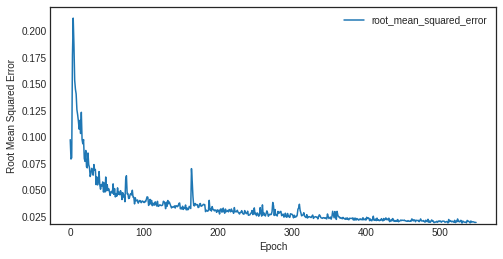

(0.5731709, 0.03176198, 0.09569881, 0.081006475)

In [72]:
# data for fit
data_wrk = data_train.copy()

#data_wrk = data_wrk.loc[data_wrk['galactic year'] >= 1000000]

#outliers

#for i in range(20):
#    data_wrk = data_wrk.append(data_wrk_outliers)
    
train_X = data_wrk.iloc[:,:-1]
train_y = data_wrk.iloc[:,[-1]]

train_X = fnl.fit_transform(train_X)
train_y = transform_y.fit_transform(train_y)

lr_model = init_model(first_layer)
history = lr_model.fit(train_X, train_y, sample_weight=compute_sample_weights(train_y, sample_bins), 
                callbacks=callbacks, epochs=epochs, verbose=1, batch_size=batch_size)

plot_history(history)

pred_X = data_test.sort_index().reset_index(drop=True).copy()

pred_X = fnl.transform(pred_X)
pred_y = lr_model.predict(pred_X, batch_size=batch_size)
pred_y = transform_y.inverse_transform(pred_y)
pred_y.max(), pred_y.min(), pred_y.mean(), pred_y.std()

In [239]:
data_all_final = pd.concat([data_train, data_test.join(pd.DataFrame(pred_y, columns=['y']))], keys=['train', 'test'])
data_all_final.sort_values(by='y', ascending=False).iloc[:20].transpose()


train               \
                                                           3603         3731   
galactic year                                           1013042      1014049   
galaxy                                              Cetus Dwarf  Cetus Dwarf   
existence expectancy index                                 1.12         1.13   
existence expectancy at birth                             88.28        87.22   
Gross income per capita                               56,524.75    55,587.40   
Income Index                                               1.12         1.13   
Expected years of education (galactic years)              23.21        23.49   
Mean years of education (galactic years)                  16.98        16.24   
Intergalactic Development Index (IDI)                      1.06         1.06   
Education Index                                            1.11         1.27   
Intergalactic Development Index (IDI), Rank               39.04        85.59   
Population using at least basic drinking-water ...       116.31       119.84   
Population using at least basic sanitation serv...       152.88       132.35   
Gross capital formation (% of GGP)                        23.14        24.18   
Population, total (millions)                             366.35       481.42   
Population, urban (%)                                    110.87       109.73   
Mortality rate, under-five (per 1,000 live births)        36.20        58.79   
Mortality rate, infant (per 1,000 live births)            15.31        31.64   
Old age dependency ratio (old age (65 and older...        27.07        25.41   
Population, ages 15–64 (millions)                        430.79       366.25   
Population, ages 65 and older (millions)                  59.78        41.01   
Life expectancy at birth, male (galactic years)           93.55        89.69   
Life expectancy at birth, female (galactic years)         94.39        91.80   
Population, under age 5 (millions)                        55.06        59.52   
Young age (0-14) dependency ratio (per 100 crea...        54.41        57.82   
Adolescent birth rate (births per 1,000 female ...        54.40        63.60   
Total unemployment rate (female to male ratio)             2.30         2.50   
Vulnerable employment (% of total employment)             28.43        24.41   
Unemployment, total (% of labour force)                   14.90        11.43   
Employment in agriculture (% of total employment)         17.43        24.55   
Labour force participation rate (% ages 15 and ...        82.93        89.80   
Labour force participation rate (% ages 15 and ...        83.48        92.06   
Employment in services (% of total employment)           101.88        86.75   
Labour force participation rate (% ages 15 and ...        89.41        84.47   
Employment to population ratio (% ages 15 and o...        82.24        78.34   
Jungle area (% of total land area)                        24.18        19.42   
Share of employment in nonagriculture, female (...        59.23        59.87   
Youth unemployment rate (female to male ratio)             1.18         1.23   
Unemployment, youth (% ages 15–24)                        24.59        23.45   
Mortality rate, female grown up (per 1,000 people)       130.47       135.04   
Mortality rate, male grown up (per 1,000 people)         134.31       239.69   
Infants lacking immunization, red hot disease (...        22.91        21.69   
Infants lacking immunization, Combination Vacci...        14.09        16.45   
Gross galactic product (GGP) per capita               56,938.99    58,222.30   
Gross galactic product (GGP), total                    6,763.73     7,708.59   
Outer Galaxies direct investment, net inflows (...        20.57        19.23   
Exports and imports (% of GGP)                           143.83       149.31   
Share of seats in senate (% held by female)               49.45        51.45   
Natural resource depletion                                

In [73]:
val = pd.DataFrame(transform_y.inverse_transform(lr_model.predict(train_X))).join(train_y.reset_index())
val['dif'] = abs(val[0] - val['y'])
display(val.agg(['max', 'mean', 'min', 'std', 'median']))
display(val.sort_values('dif', ascending=False))

0    index    y  dif
max    0.67 3,864.00 0.68 0.15
mean   0.09 1,932.00 0.08 0.01
min    0.03     0.00 0.01 0.00
std    0.06 1,115.87 0.06 0.01
median 0.06 1,932.00 0.06 0.01

0  index    y  dif
1539 0.19   3716 0.04 0.15
3845 0.15   3491 0.04 0.11
749  0.21   3045 0.11 0.10
3780 0.15    824 0.06 0.10
3844 0.15   3415 0.05 0.09
...   ...    ...  ...  ...
3586 0.05   1629 0.05 0.00
1130 0.05    906 0.05 0.00
20   0.05    391 0.05 0.00
19   0.05    248 0.05 0.00
583  0.05   1429 0.05 0.00

[3865 rows x 4 columns]

# Energy split

In [74]:
from scipy.optimize import Bounds, LinearConstraint, minimize, HessianUpdateStrategy
import numpy as np
import pandas as pd

pred = pred_y.reshape(1,-1)[0]
sz = len(pred)

def func_en(En):
    #print(-sum(En * ((-np.log(pred + 0.01) + 3) ** 2 / 1000)))
    return -sum(En * ((-np.log(pred + 0.01) + 3) ** 2 / 1000))

bounds = Bounds(0, 1)
linear_constraint = LinearConstraint([np.array(data_test['existence expectancy index'] < 0.7).astype('float'),
                                      np.ones(sz)], [50, 0], [np.inf, 500])

En0 = np.random.random(sz);
res = minimize(func_en, En0, method='trust-constr', jac='2-point', \
                   constraints=[linear_constraint], \
                   options={'verbose': 1}, bounds=bounds)


`gtol` termination condition is satisfied.
Number of iterations: 30, function evaluations: 19602, CG iterations: 23, optimality: 4.58e-09, constraint violation: 0.00e+00, execution time: 1.6e+02 s.


In [75]:
res.fun
#16.84650144962803
#17.935576687882783
#18.828106719581477

#17.66035012246038

-17.18002347894332

In [ ]:
from scipy.optimize import basinhopping
minimizer_kwargs = {"method":"trust-constr", "jac":'2-point', 'constraints':[linear_constraint], 'bounds': bounds}
En0 = np.random.random(sz);
ret = basinhopping(func_en, En0, minimizer_kwargs=minimizer_kwargs,
                    niter=10)

In [ ]:
ret.fun
#-16.84617913608769

# Prepare submit

In [76]:
data_submit = pd.DataFrame()
data_submit['pred'] = pred
data_submit['opt_pred'] = res.x * 100
data_submit.reset_index().to_csv('submit.csv', index=False, float_format='%.8f')

In [ ]:
(pd.concat([pd.read_csv('submit.csv')['opt_pred'], pd.Series(res.x*100)], axis=1)).sum()